In [12]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz


In [13]:
pd.set_option('max_columns', None)
FILE_NAME = "lawsuit_k_supp2"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [14]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [15]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [16]:
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1

In [17]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']

In [18]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [19]:
import ast

result = pd.DataFrame(columns=["k", "depth", "random_state", "clf.error_", "clf.accuracy_", "accuracy_pred", "accuracy_test", "sum_misclassified_train", "sum_discrimination_additive_train_abs", "sum_discrimination_additive_train_pred_abs", "sum_discrimination_additive_train", "sum_discrimination_additive_train_pred", "discrimination_train", "discrimination_train_pred" ,"discrimination_test",  "duration", "min_supp", "clf.tree_"])

def xx(clf):
    print(f"### Depth: {depth} state: {random_state} k:{k} ###")
    start = time.perf_counter()
    print(f"Model building...")
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    print("Model built. Duration of building =", round(duration, 8))
    print("clf.accuracy_ =", round(clf.accuracy_, 8))
    y_pred_train = clf.predict(X_train)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    print("Accuracy DL8.5 on training set =", accuracy_pred)
    y_pred_test = clf.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    print("Accuracy DL8.5 on test set =", accuracy_test)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    print("Discrimination of classifier on train", discrimination_train)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    print("Discrimination of classifier on train(pred)", discrimination_train_pred)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)
    print("Discrimination of classifier on test", discrimination_test)
    print(f"error: {clf.error_}")


    utils.tree_upgrade(clf.tree_, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', do_abs=True),8)

    utils.tree_upgrade(clf.tree_, y_train, sensitive_train)
    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    result.loc[len(result.index)] = [k, depth, random_state, clf.error_, clf.accuracy_, accuracy_pred, accuracy_test, sum_misclassified_train, sum_discrimination_additive_train_abs, sum_discrimination_additive_train_pred_abs, sum_discrimination_additive_train, sum_discrimination_additive_train_pred, discrimination_train, discrimination_train_pred ,discrimination_test,  duration, min_supp, clf.tree_]

if False:
    for depth in [1, 2, 3, 4, 5, 6, 7]:
        #for min_supp in range(1, len(X_train), int(len(X_train)/4)):
        for min_supp in range(2,3):
            for random_state in range(1, 101, 2):
                for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
                    if random_state in [17, 35, 43, 71, 91]:
                        continue
                    X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)

                    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)
                    xx(clf)
                    print()
        result.to_csv('save/'+FILE_NAME+'.csv', index=False)

In [20]:
result = pd.read_csv('save/'+FILE_NAME+".csv")
result = result.sort_values(['k', 'depth', 'min_supp'])
result

,k,depth,random_state,clf.error_,clf.accuracy_,accuracy_train,accuracy_test,sum_misclassified_train,sum_discrimination_additive_pred_abs,sum_discrimination_additive_train_abs,sum_discrimination_additive_train,sum_discrimination_additive_train_pred,discrimination_train,discrimination_train_pred,discrimination_test,duration,min_supp,clf.tree_
0,0,1,1,51.000000,0.755981,0.755981,0.730769,51,0.156476,0.325619,0.325619,0.156476,0.325619,0.156476,0.266667,0.034566,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
11,0,1,3,48.000000,0.770335,0.770335,0.673077,48,0.234535,0.304364,0.304364,0.234535,0.304364,0.234535,-0.046083,0.028197,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
22,0,1,5,49.000000,0.765550,0.765550,0.692308,49,0.179566,0.324563,0.324563,0.179566,0.324563,0.179566,0.172619,0.032429,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
33,0,1,7,51.000000,0.755981,0.755981,0.730769,51,0.185791,0.290782,0.290782,0.185791,0.290782,0.185791,0.137931,0.027037,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
44,0,1,9,54.000000,0.741627,0.741627,0.788462,54,0.144628,0.316116,0.316116,0.144628,0.316116,0.144628,0.297386,0.036378,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,100000,7,89,31923.021484,-151.741730,0.885167,0.903846,24,0.281985,0.318990,0.318990,0.281985,0.318990,0.281985,0.151424,2.309912,2,"{'feat': 1, 'left': {'feat': 2, 'left': {'feat..."
3431,100000,7,93,29877.371094,-141.953934,0.894737,0.923077,22,0.237603,0.298554,0.298554,0.227273,0.298554,0.227273,0.421569,2.236898,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'valu..."
3442,100000,7,95,35396.804688,-168.362701,0.909091,0.846154,19,0.273318,0.353778,0.353778,0.273318,0.353778,0.273318,0.161085,2.246949,2,"{'feat': 0, 'left': {'feat': 4, 'left': {'feat..."
3453,100000,7,97,34281.562500,-163.026611,0.913876,0.807692,18,0.242636,0.342636,0.342636,0.242636,0.342636,0.242636,0.269231,2.179736,2,"{'feat': 1, 'left': {'feat': 2, 'left': {'feat..."


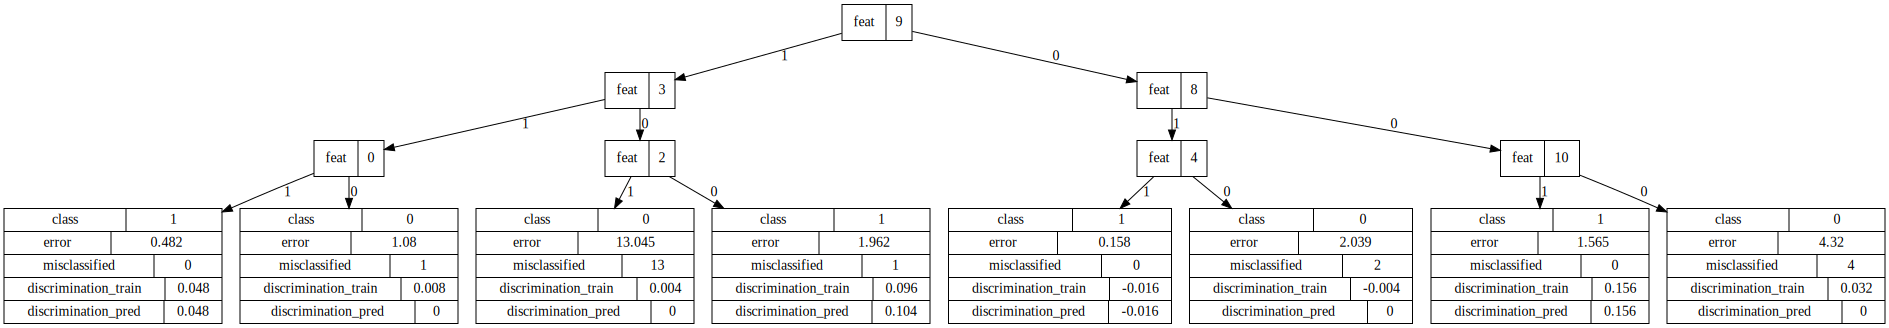

In [21]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


In [22]:
round(utils.discrimination(y_train, sensitive_train), 4)

0.3256

In [23]:
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train', do_abs=True))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred', do_abs=True))

0.3256190476190477
0.36504761904761907
0.2930476190476191
0.32466666666666666


In [24]:
utils.sum_elem_tree(clf.tree_, 'misclassified')

21

In [25]:
print(utils.discrimination(y_train, sensitive_train))
print(utils.discrimination(y_pred_train, sensitive_train))

0.32561904761904764
0.293047619047619


In [26]:
clf.tree_

{'feat': 9,
 'left': {'feat': 3,
  'left': {'feat': 0,
   'left': {'value': 1,
    'error': 0.481905,
    'transactions': [135, 169, 139, 171, 141, 142, 113, 118, 119, 151, 122],
    'proba': [0, 1.0],
    'discrimination_additive_train': 0.048190476190476186,
    'discrimination_additive_pred': 0.048190476190476186,
    'misclassified': 0},
   'right': {'value': 0,
    'error': 1.08,
    'transactions': [144, 148, 173],
    'proba': [0.6666666666666666, 0.3333333333333333],
    'discrimination_additive_train': 0.008,
    'discrimination_additive_pred': 0.0,
    'misclassified': 1},
   'transactions': [135,
    169,
    139,
    171,
    141,
    142,
    173,
    144,
    113,
    148,
    118,
    119,
    151,
    122],
   'proba': [0.14285714285714285, 0.8571428571428571]},
  'right': {'feat': 2,
   'left': {'value': 0,
    'error': 13.044762,
    'transactions': [129,
     131,
     132,
     133,
     134,
     136,
     138,
     140,
     143,
     147,
     150,
     153,
    

# Graphs

<Figure size 648x432 with 0 Axes>

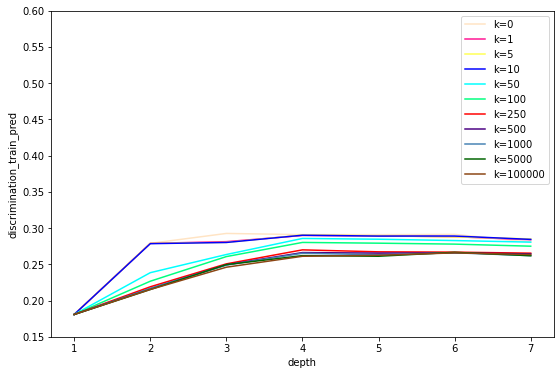

In [27]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0.15, 0.6)

<Figure size 648x432 with 0 Axes>

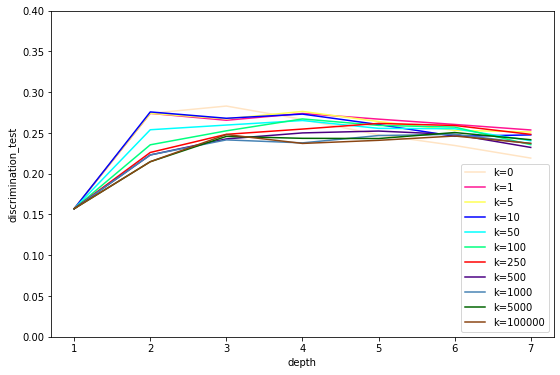

In [28]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

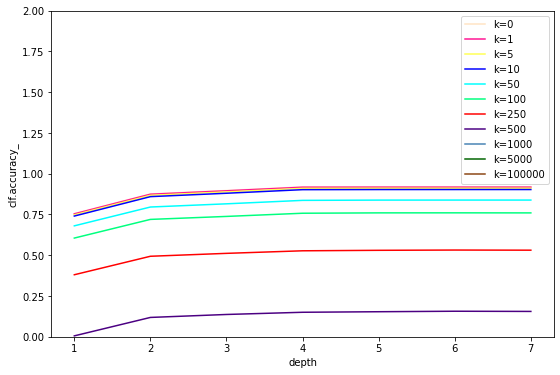

In [29]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

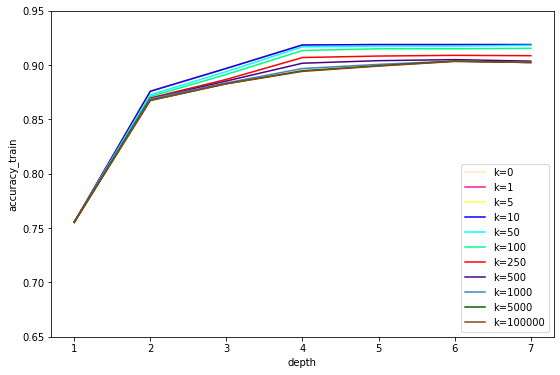

In [31]:
utils.plot_mean("depth", "accuracy_train", result, 0.65, 0.95)

<Figure size 648x432 with 0 Axes>

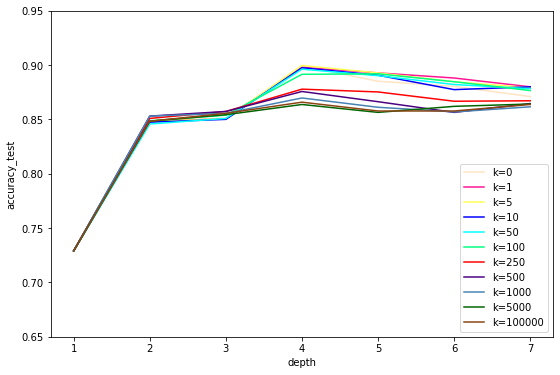

In [32]:
utils.plot_mean("depth", "accuracy_test", result, 0.65, 0.95)

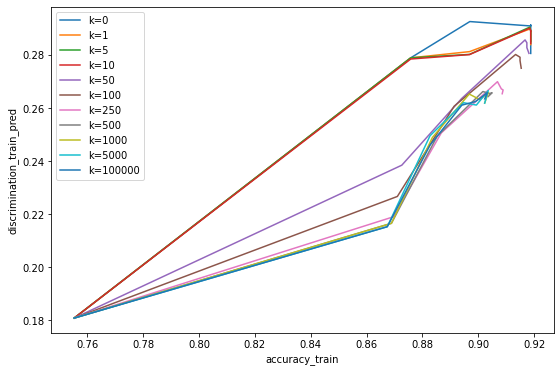

In [34]:
utils.plot2("accuracy_train", "discrimination_train_pred", result)

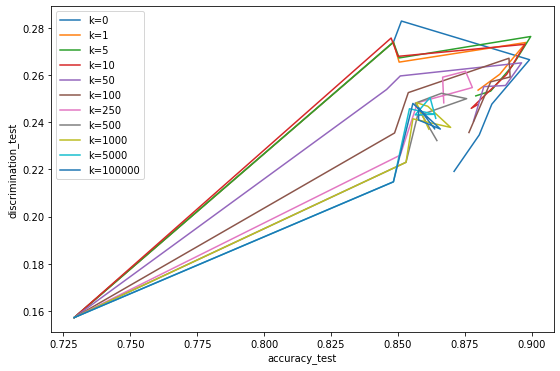

In [35]:
utils.plot2("accuracy_test", "discrimination_test", result)

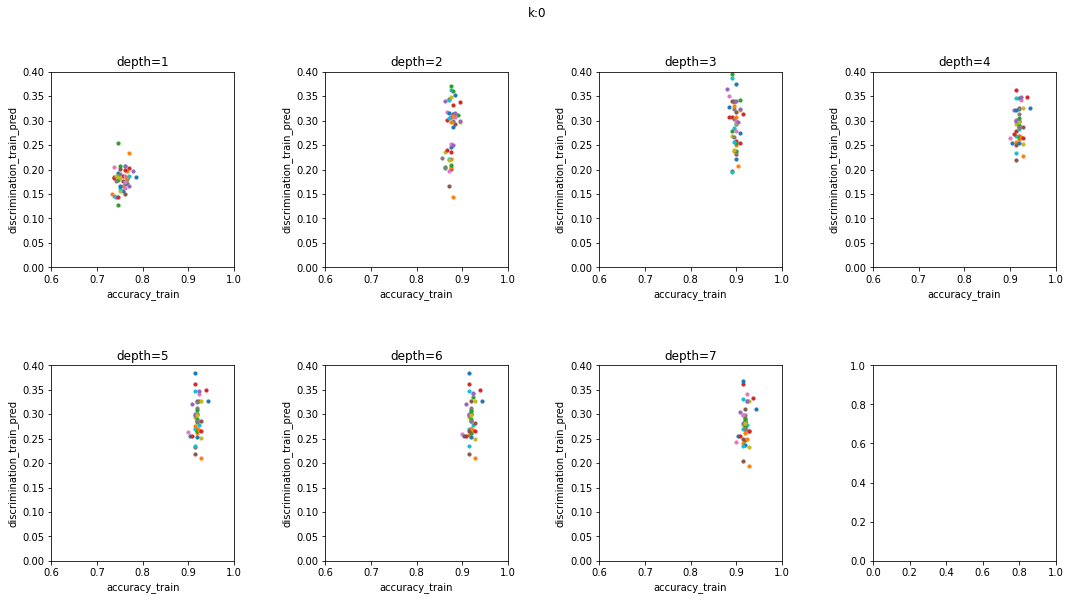

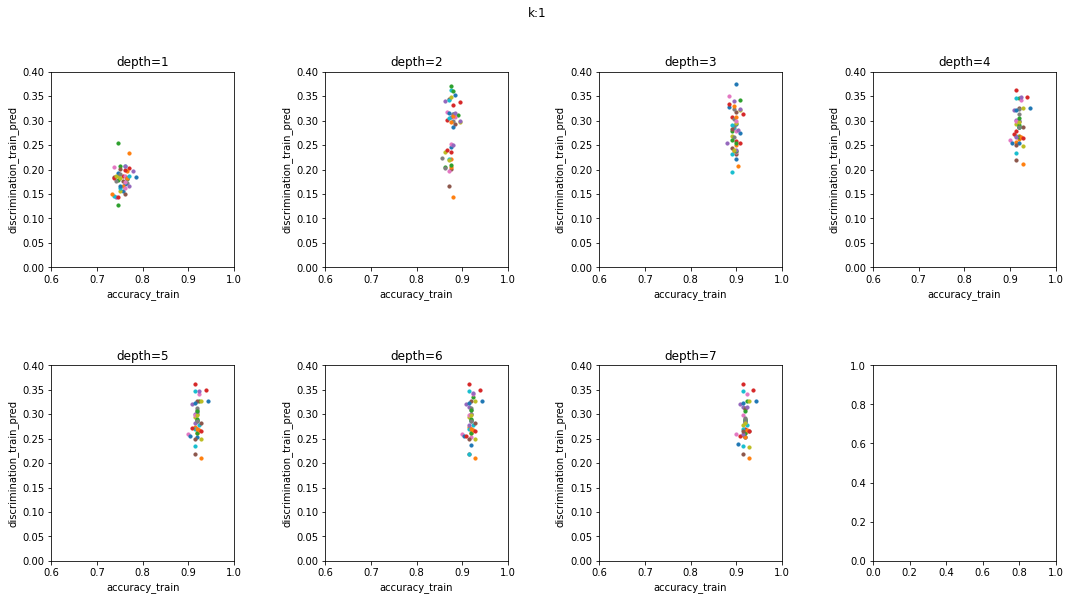

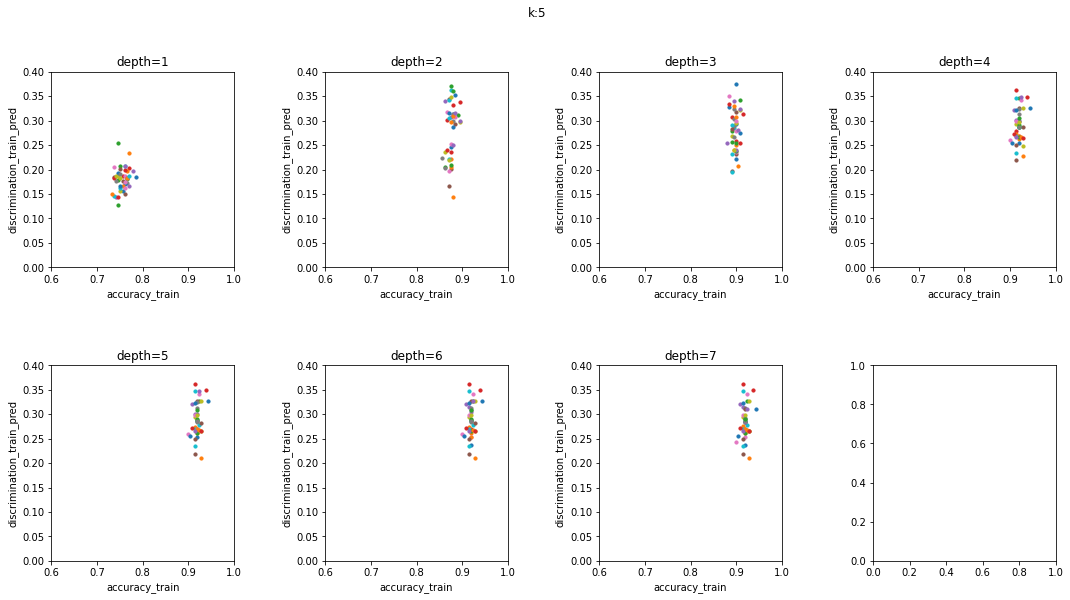

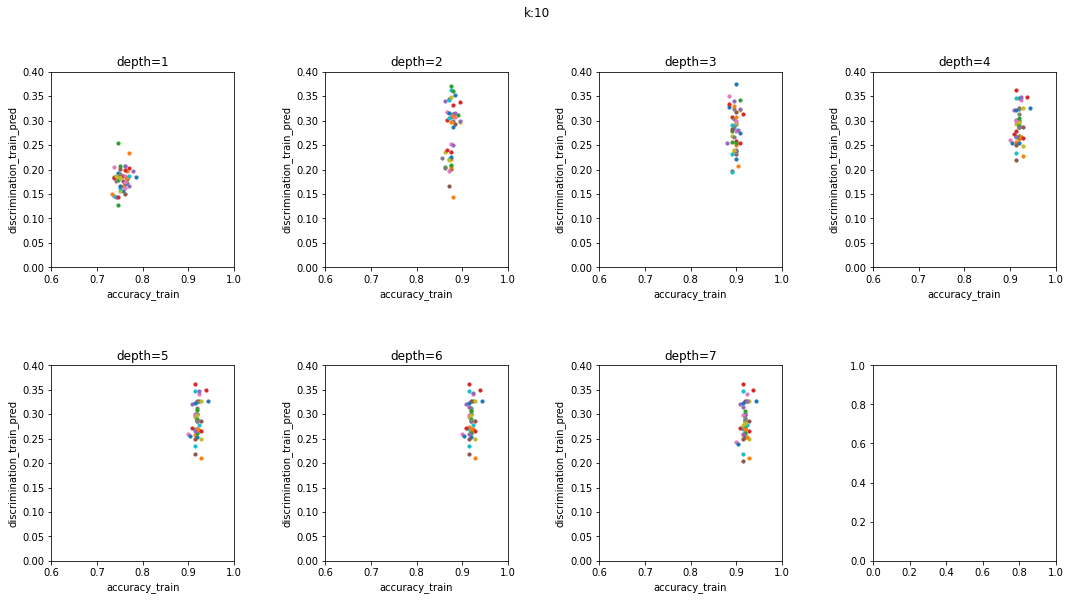

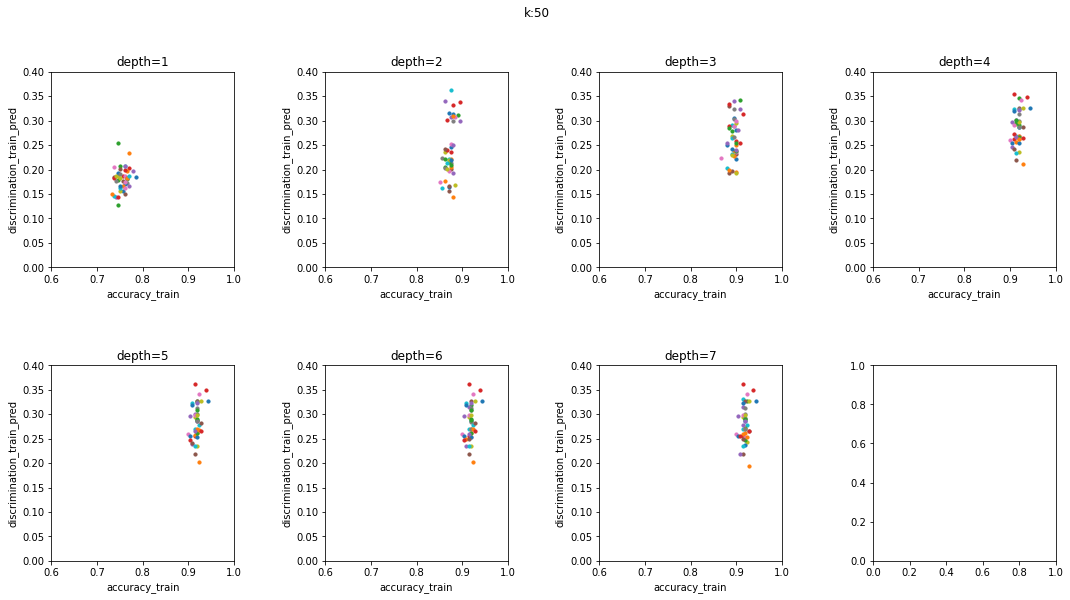

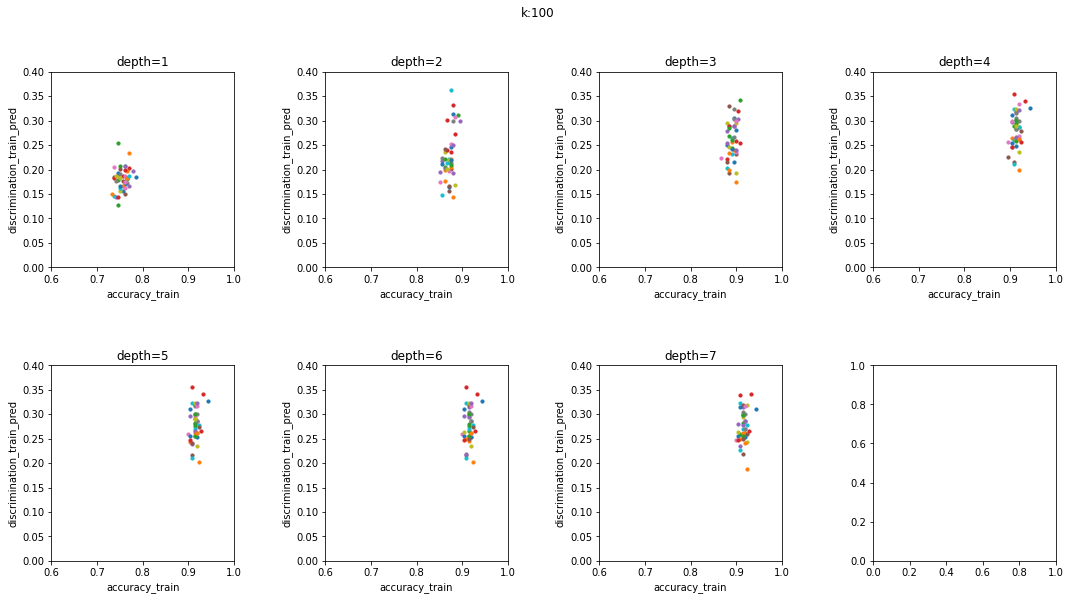

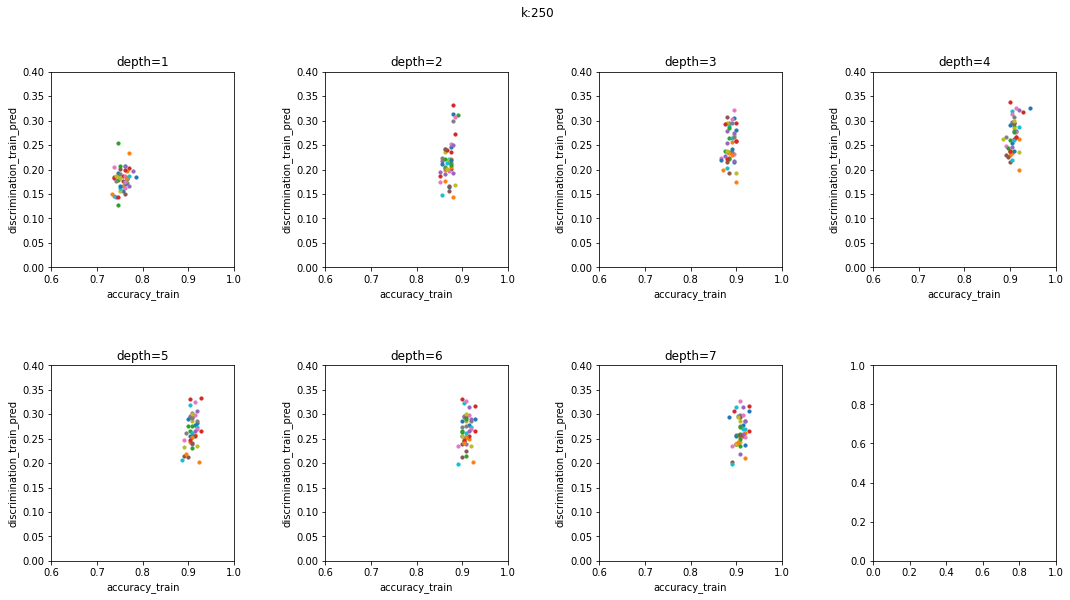

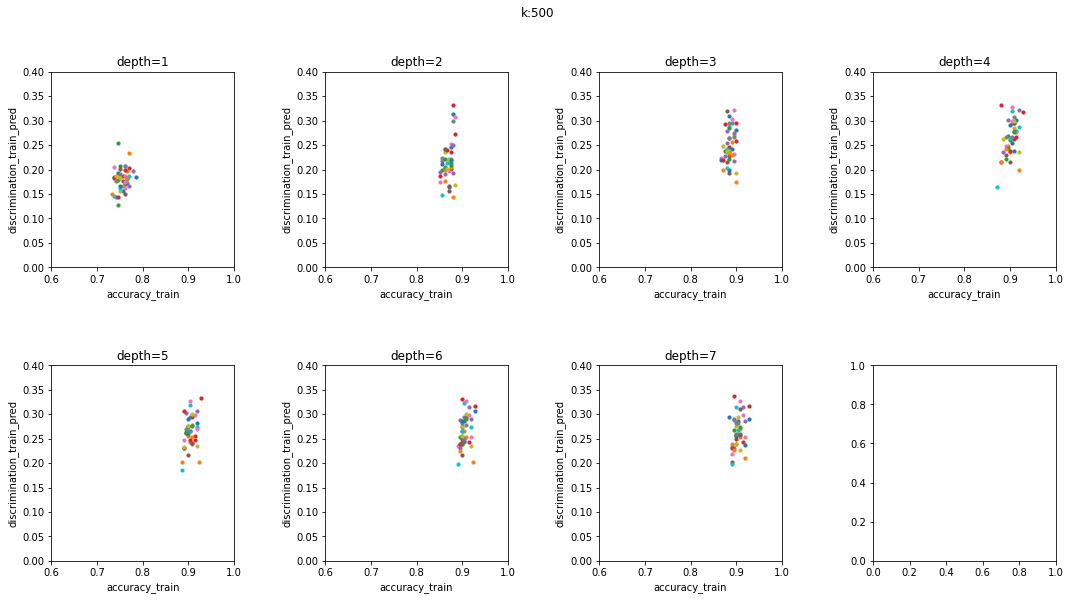

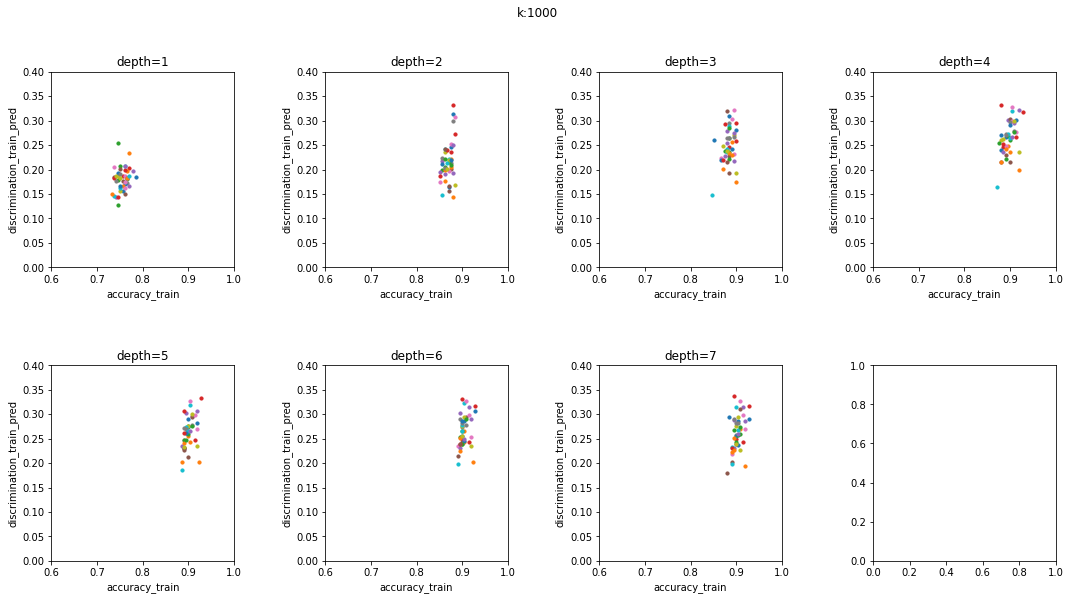

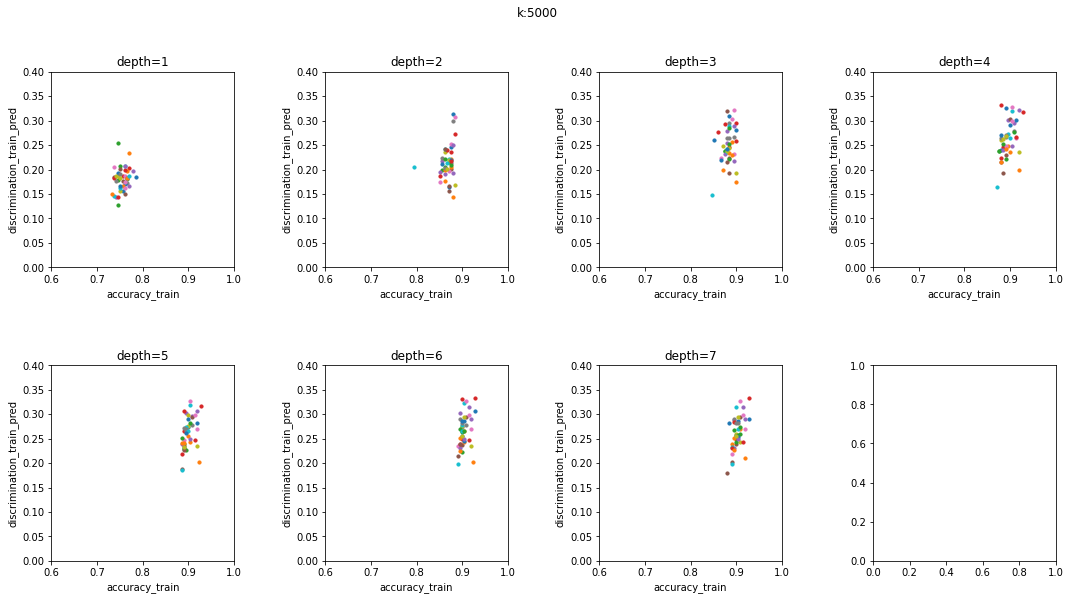

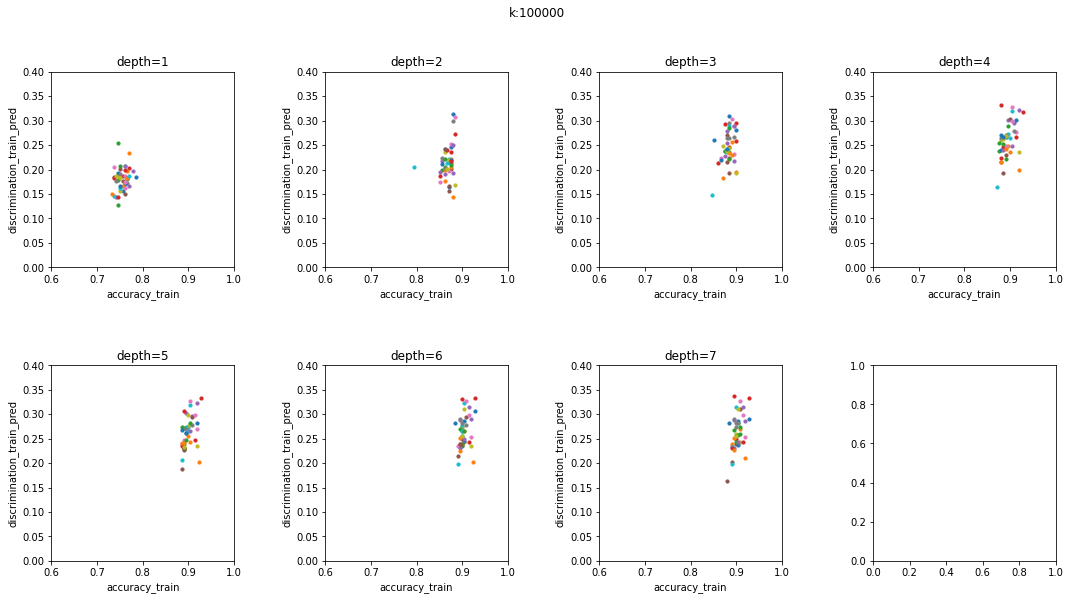

In [37]:
utils.plot_one_scatter_by_depth("accuracy_train", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

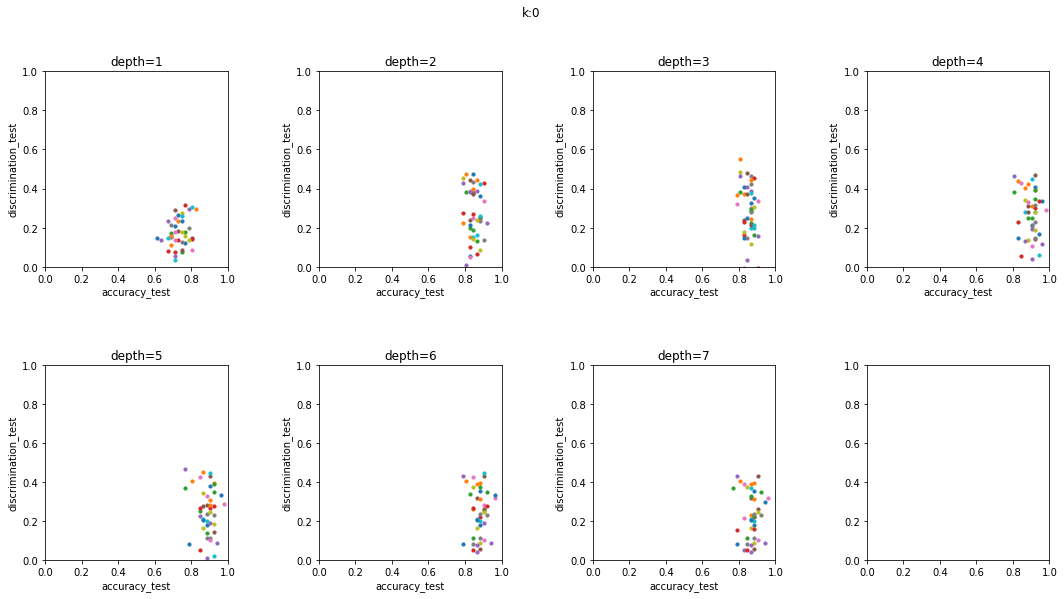

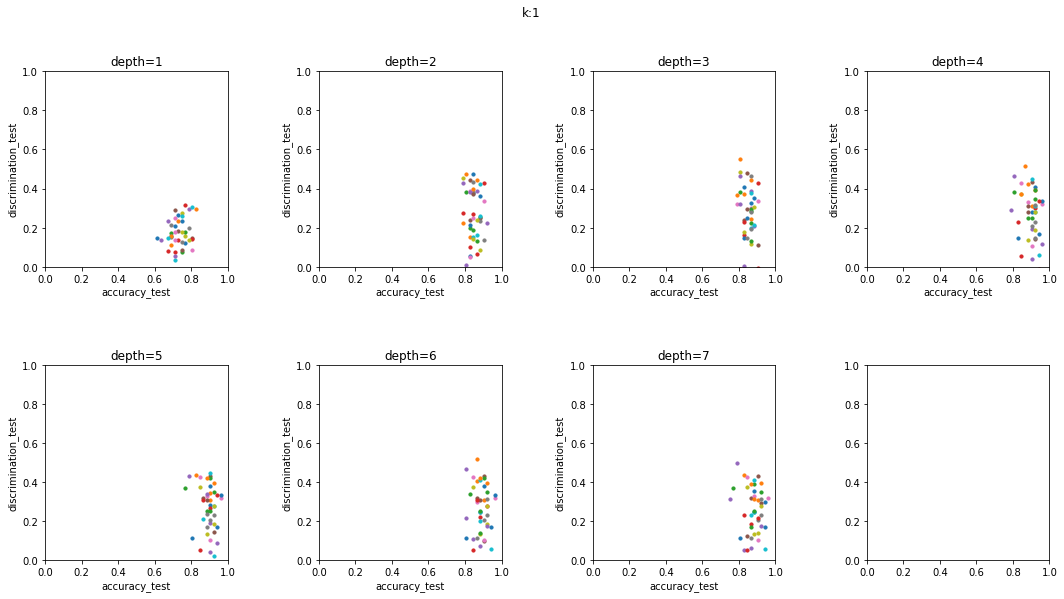

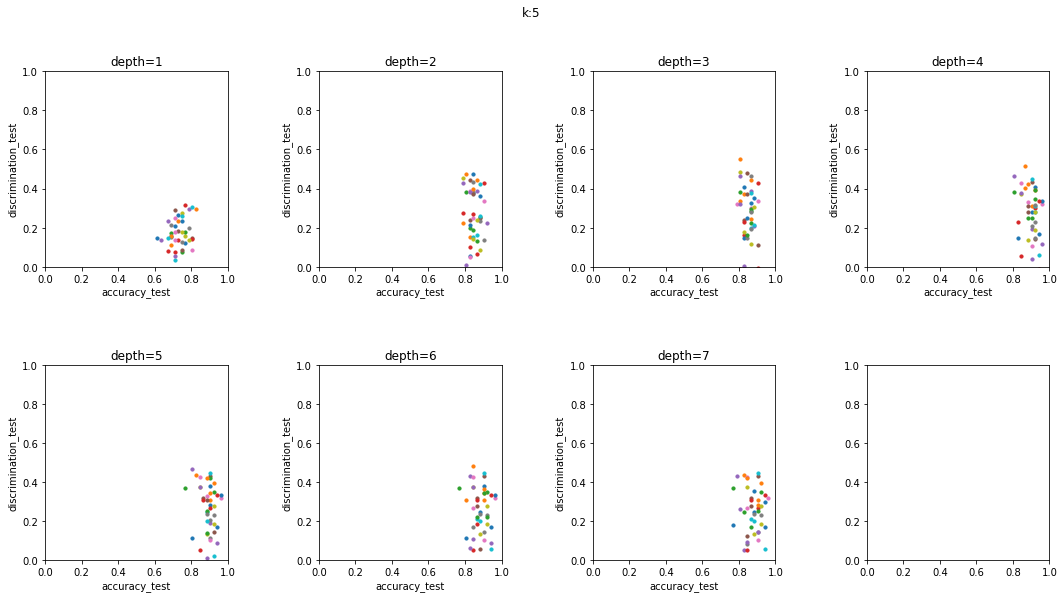

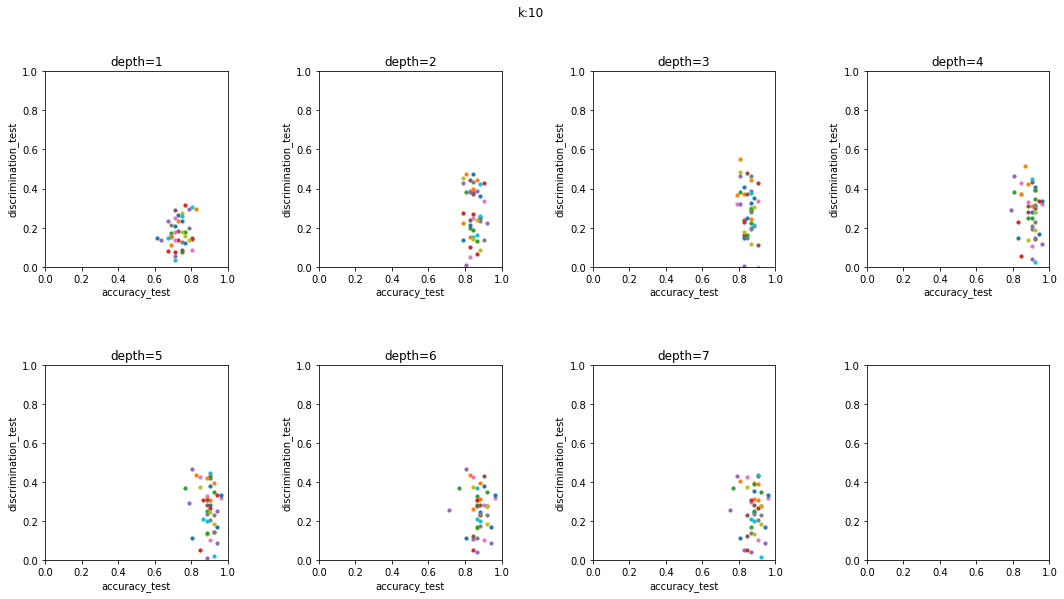

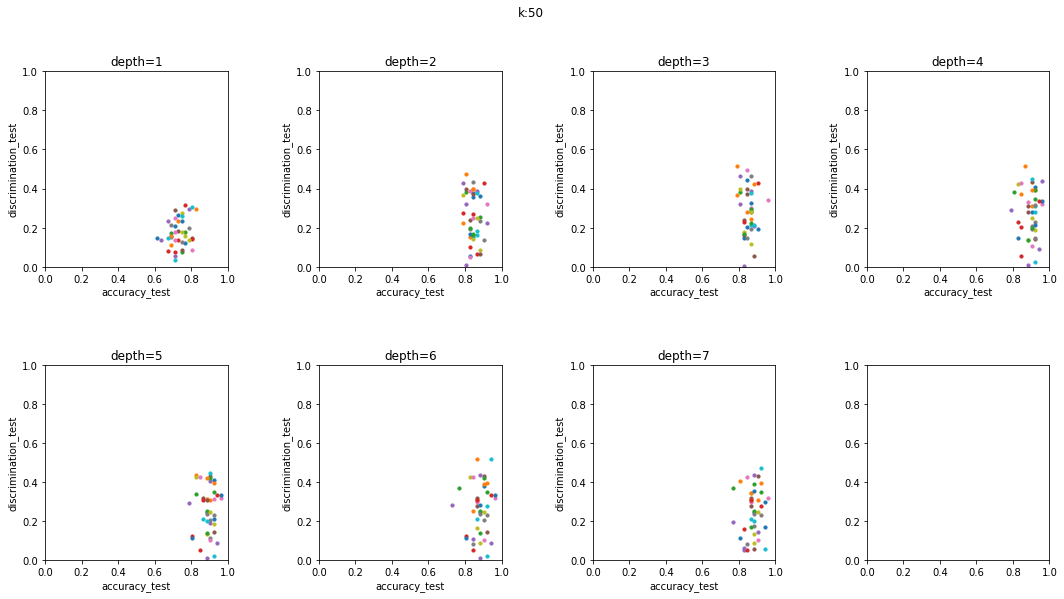

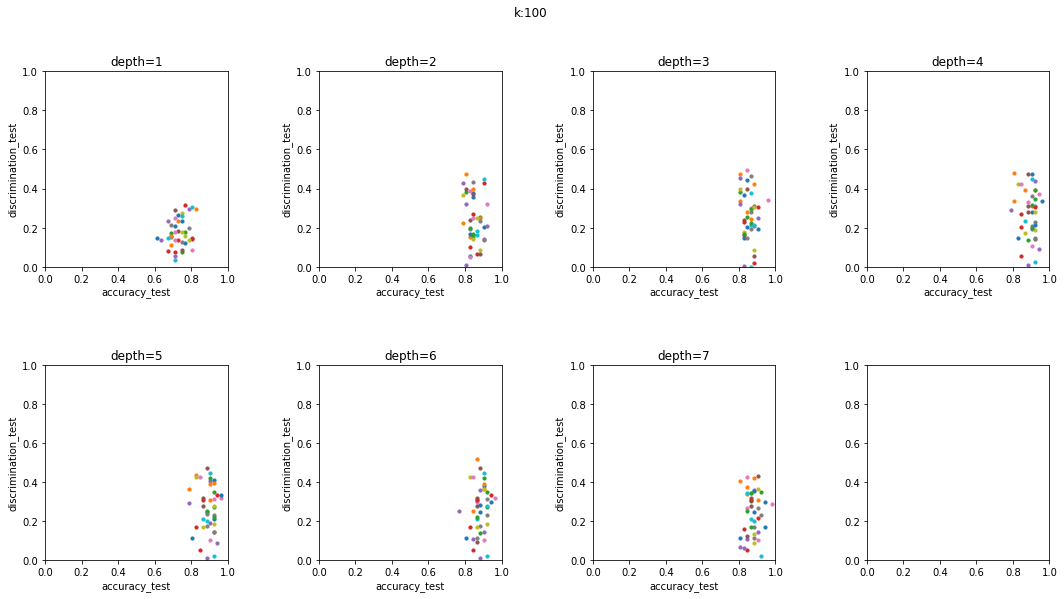

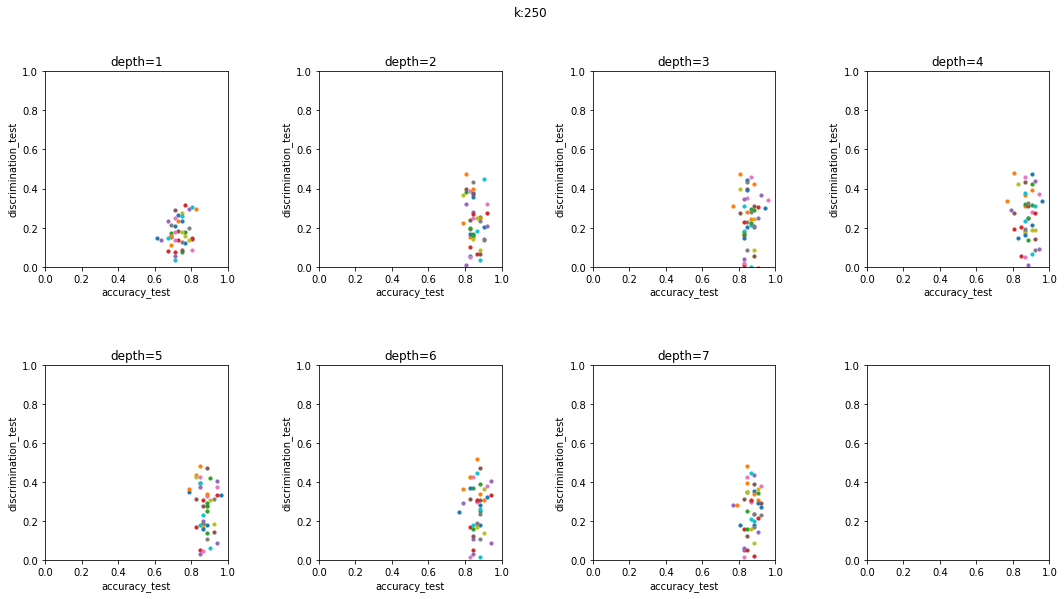

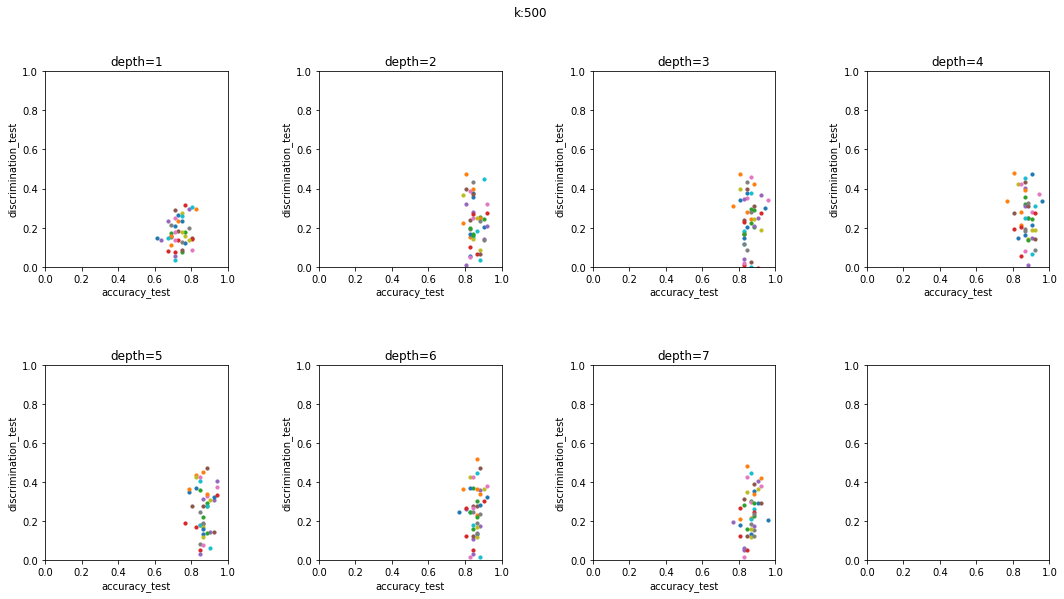

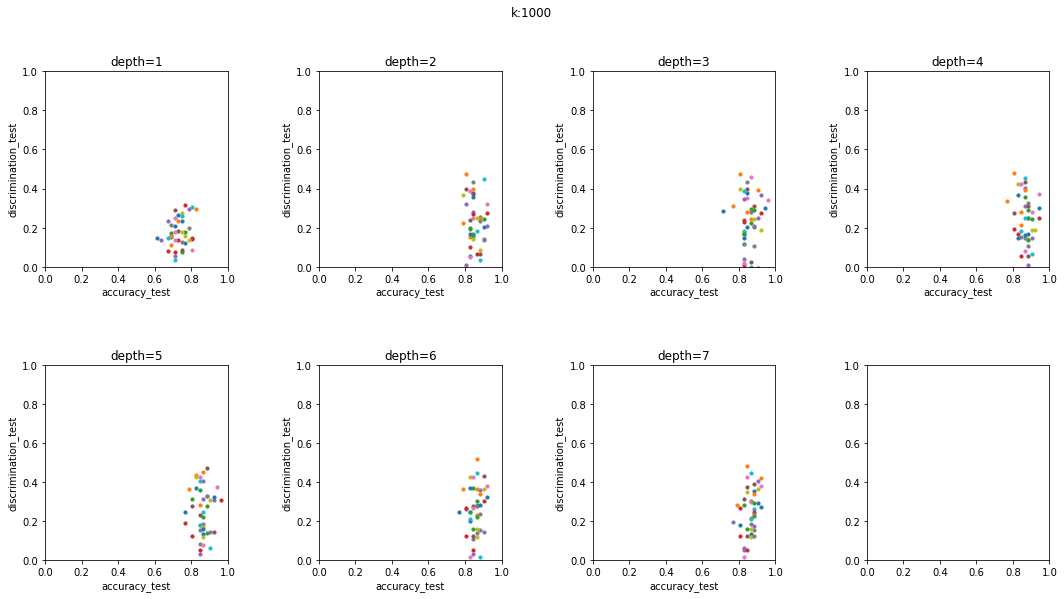

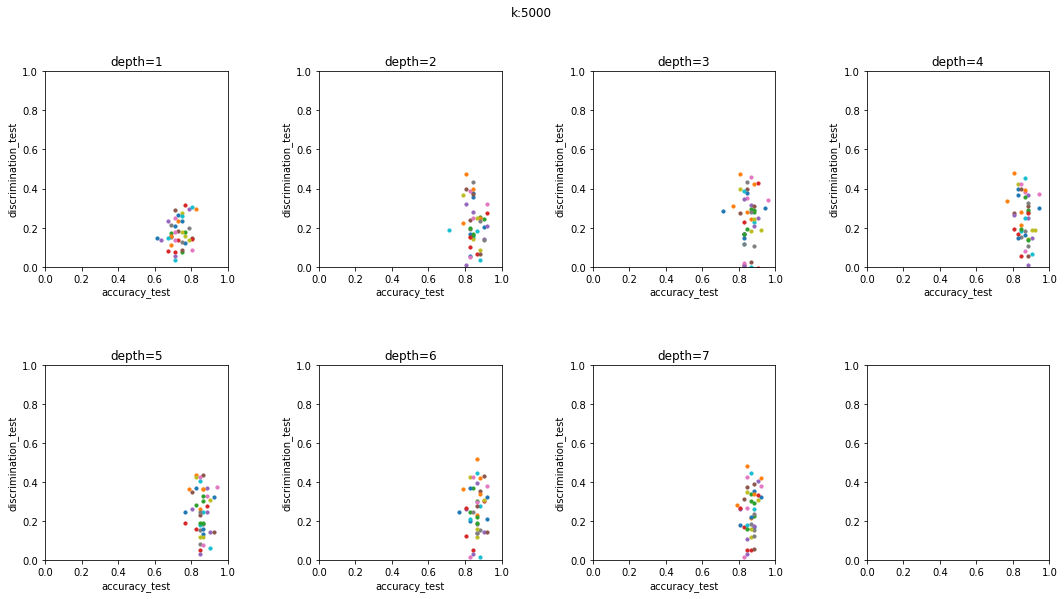

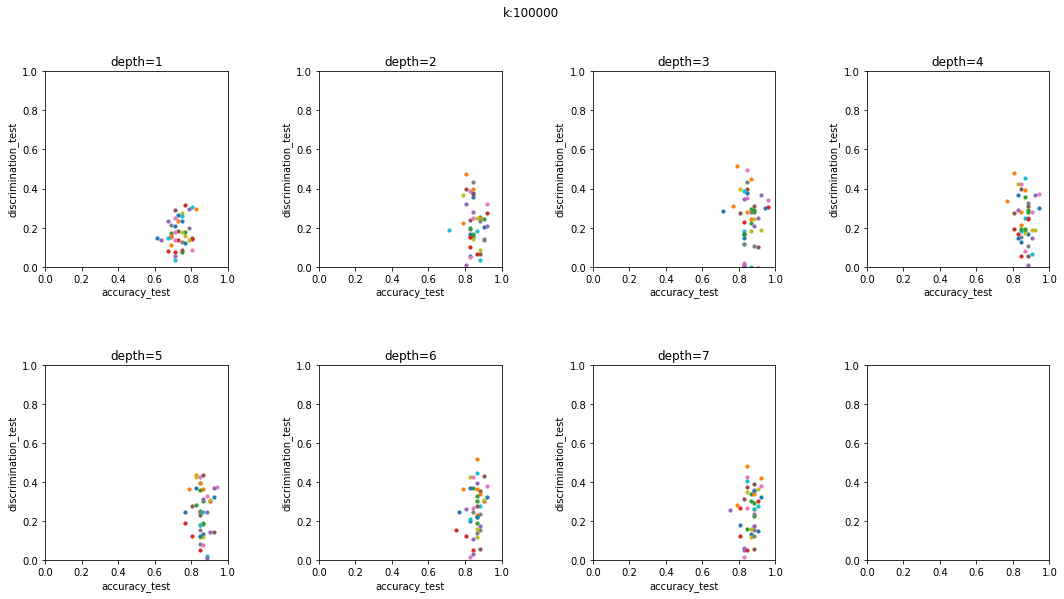

In [38]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

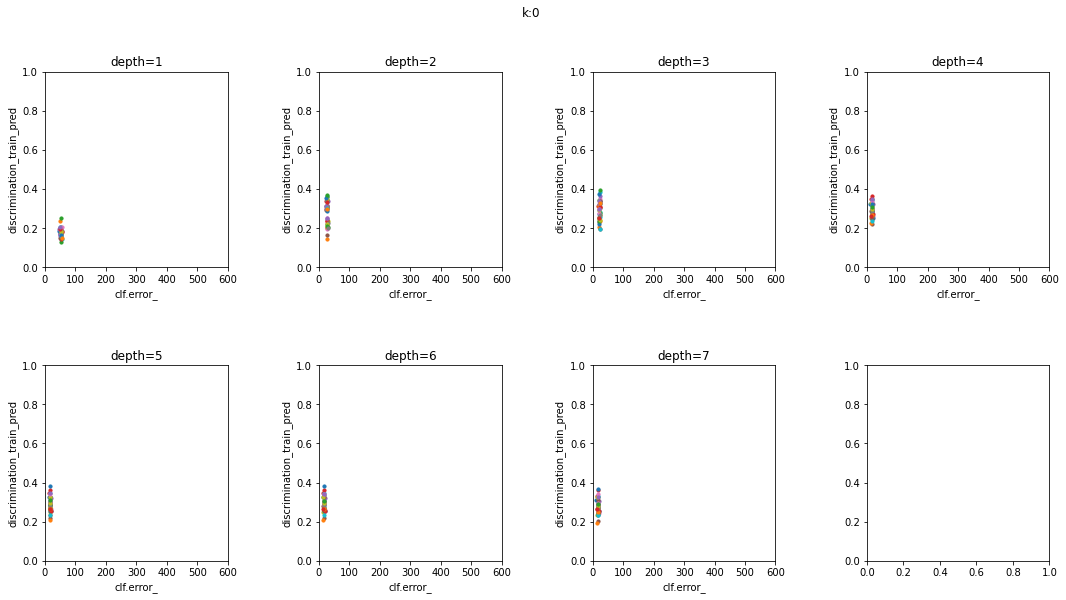

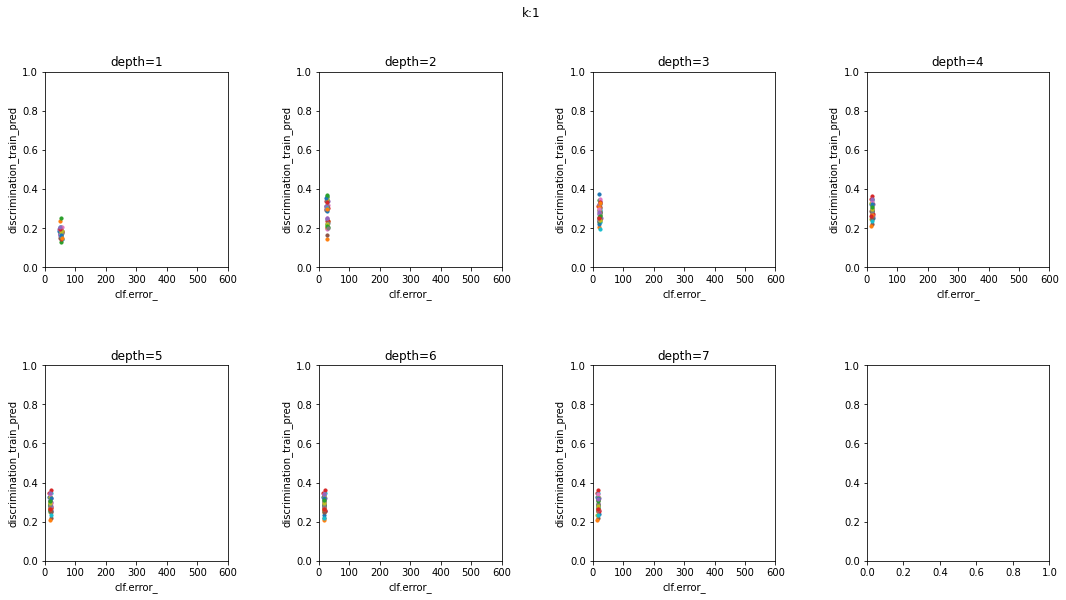

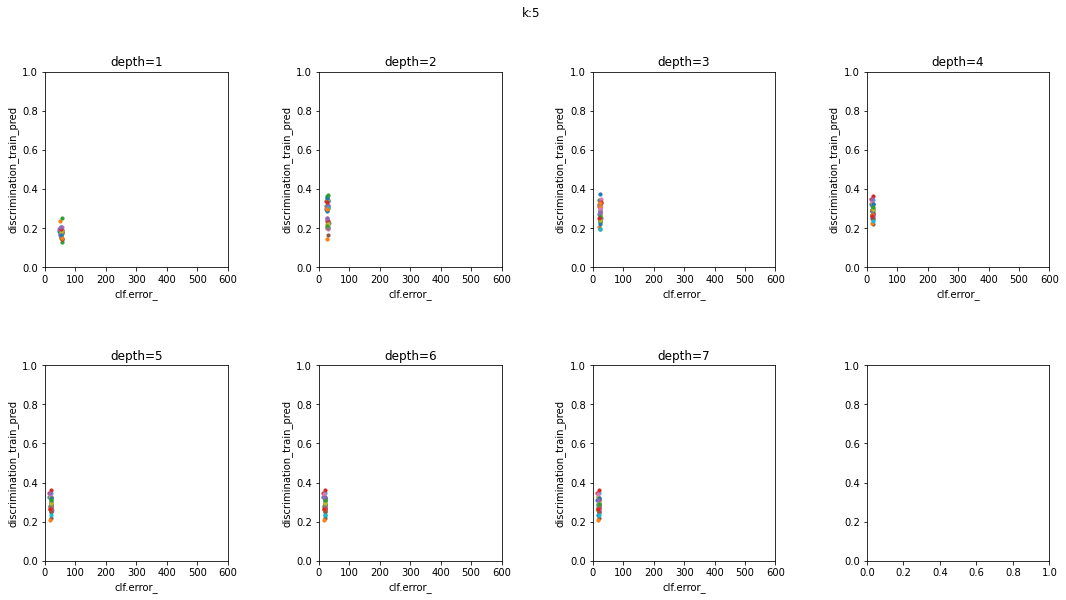

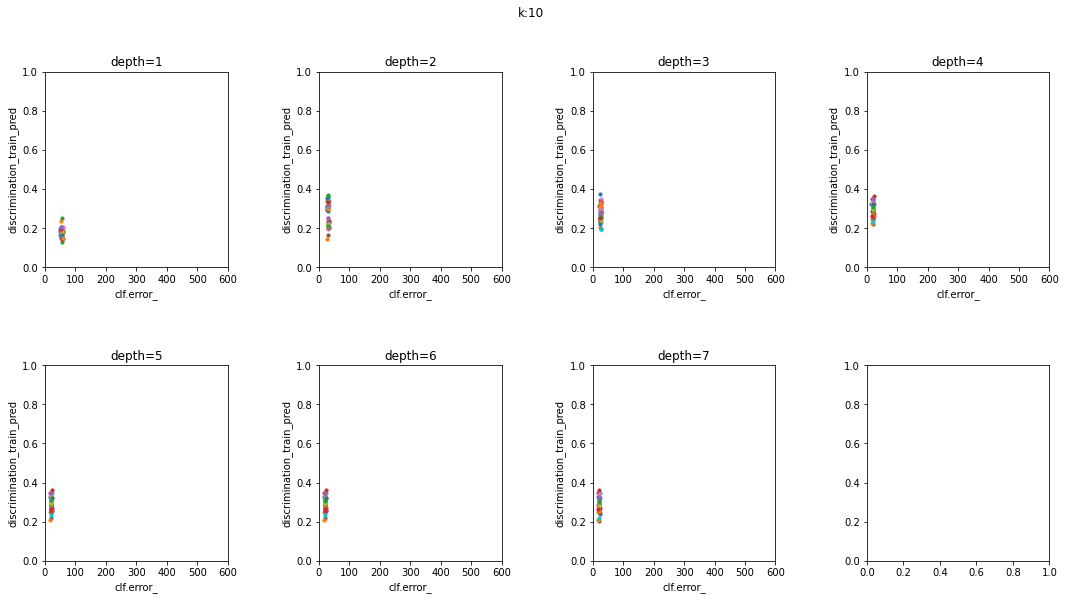

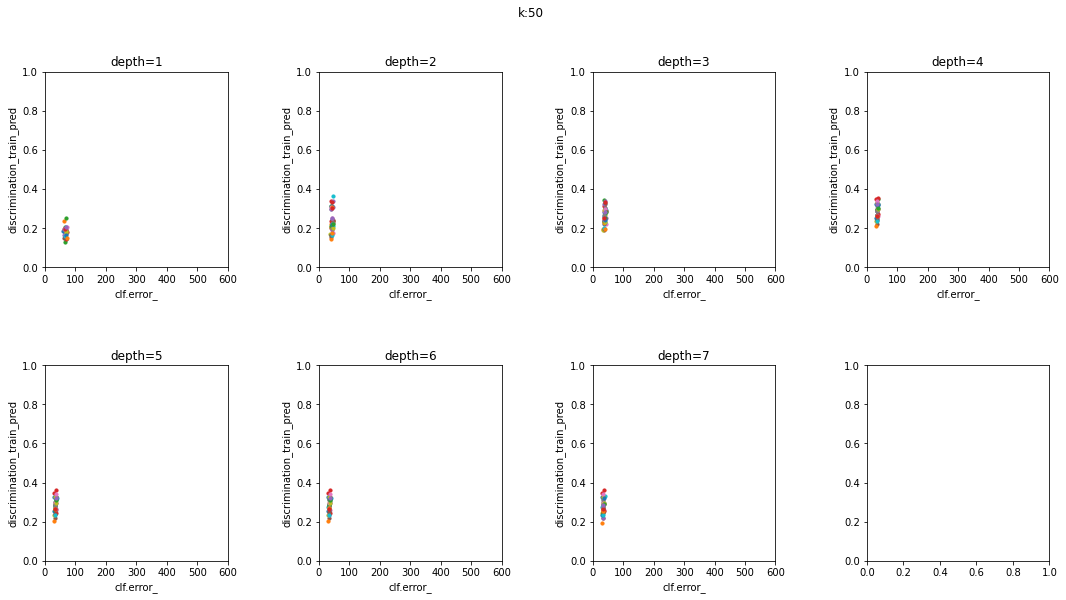

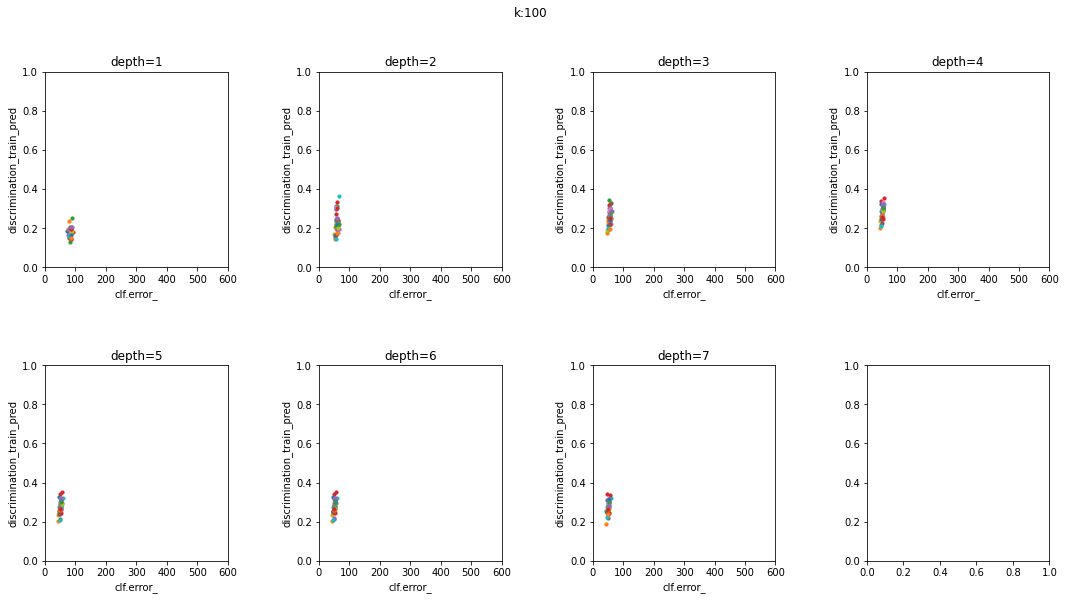

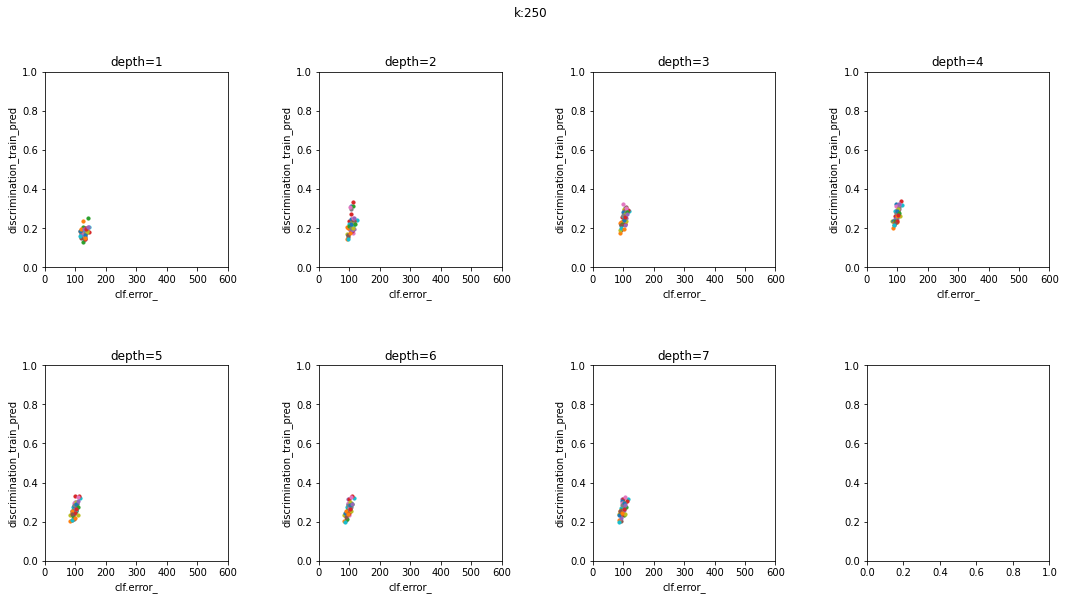

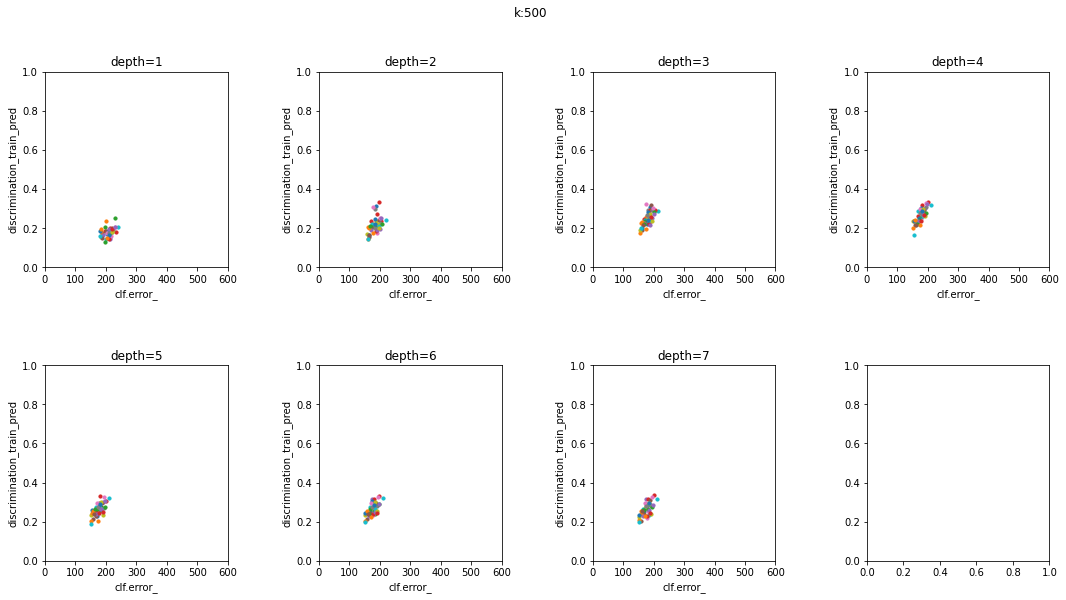

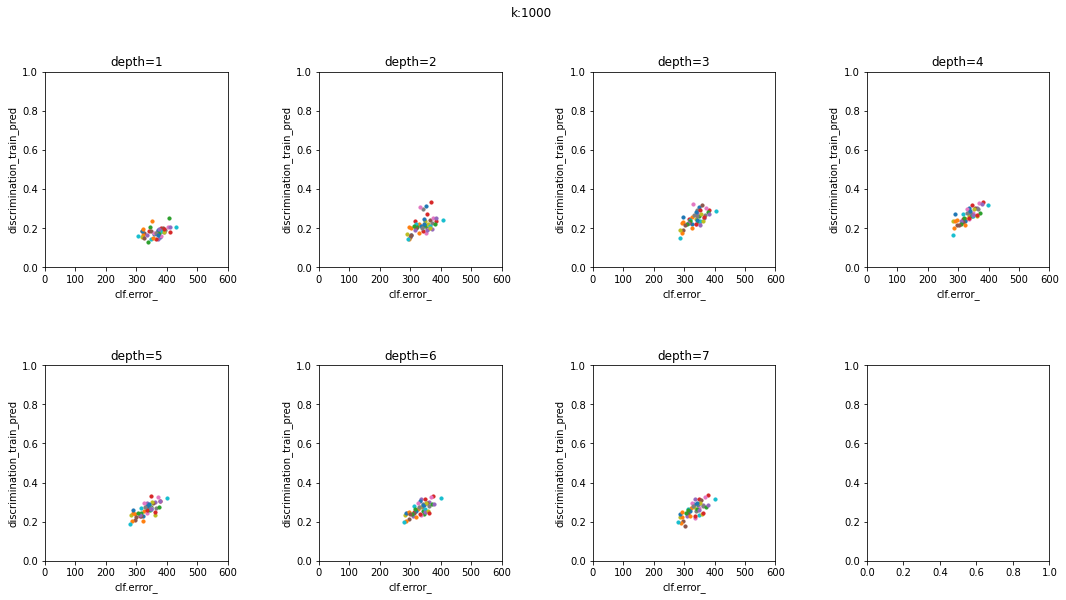

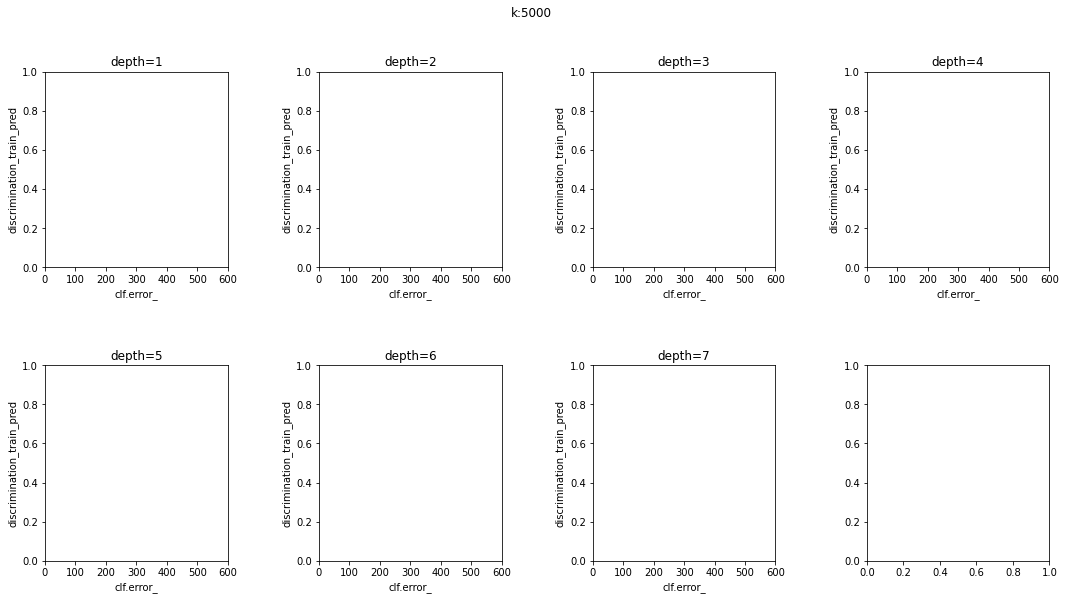

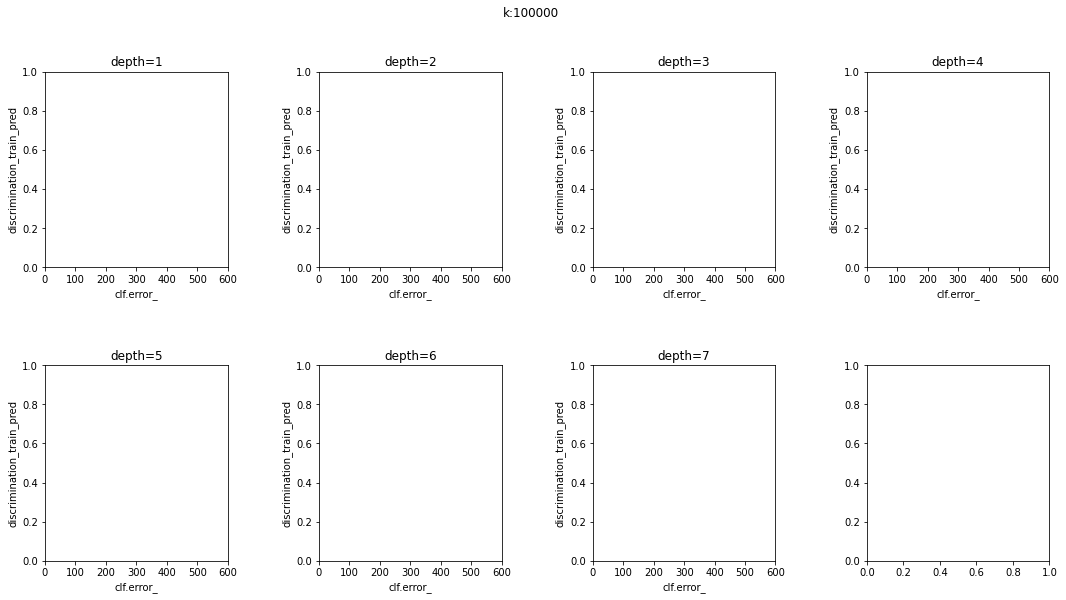

In [39]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

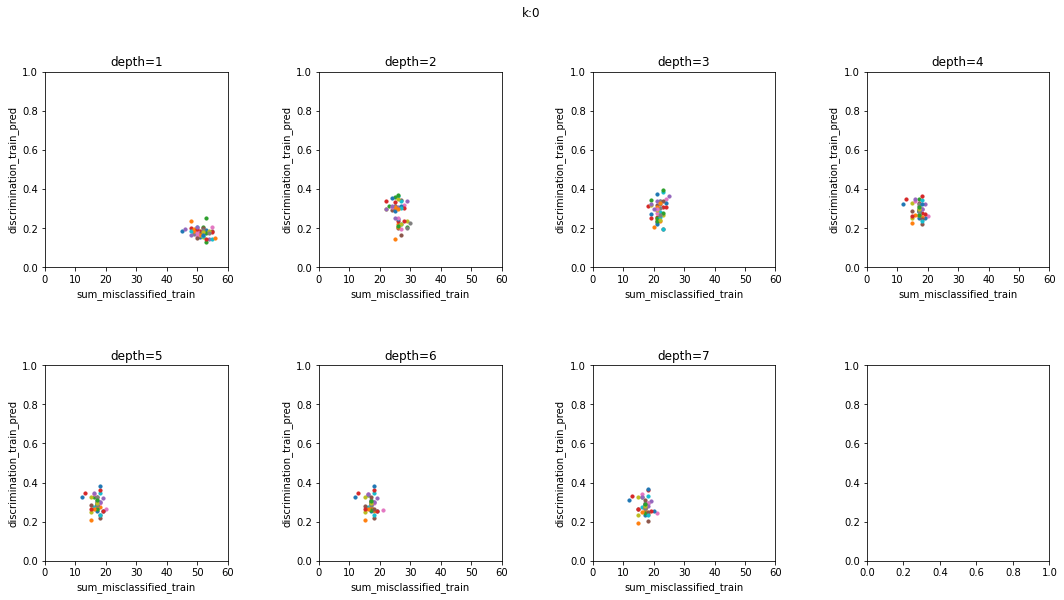

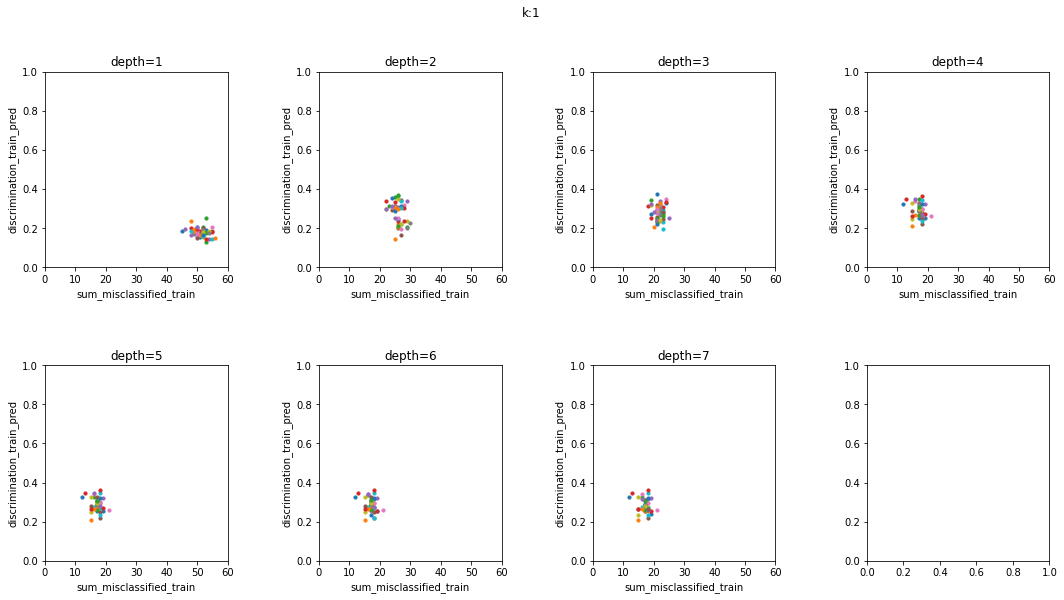

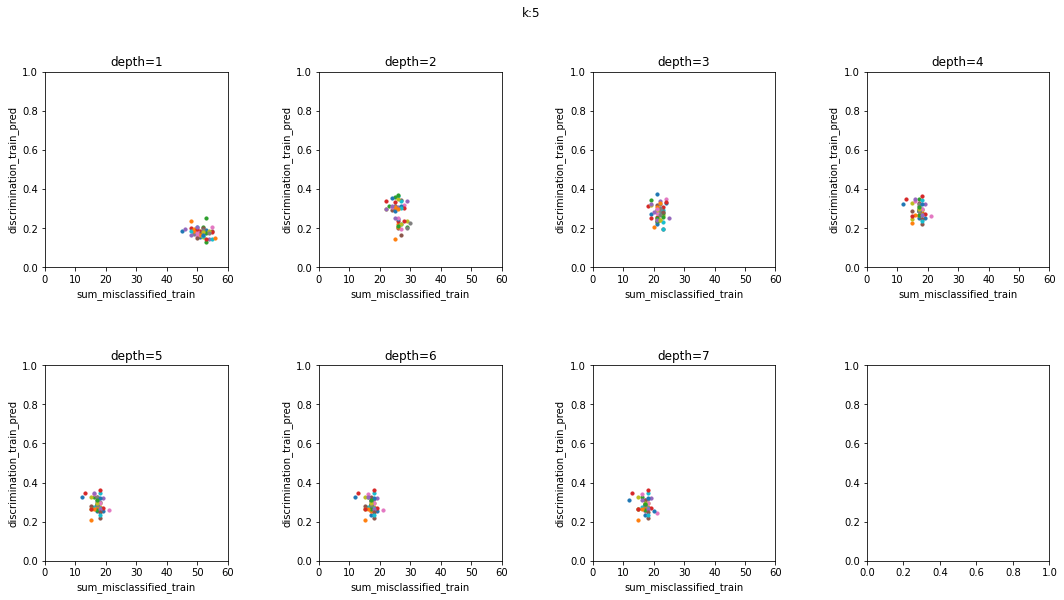

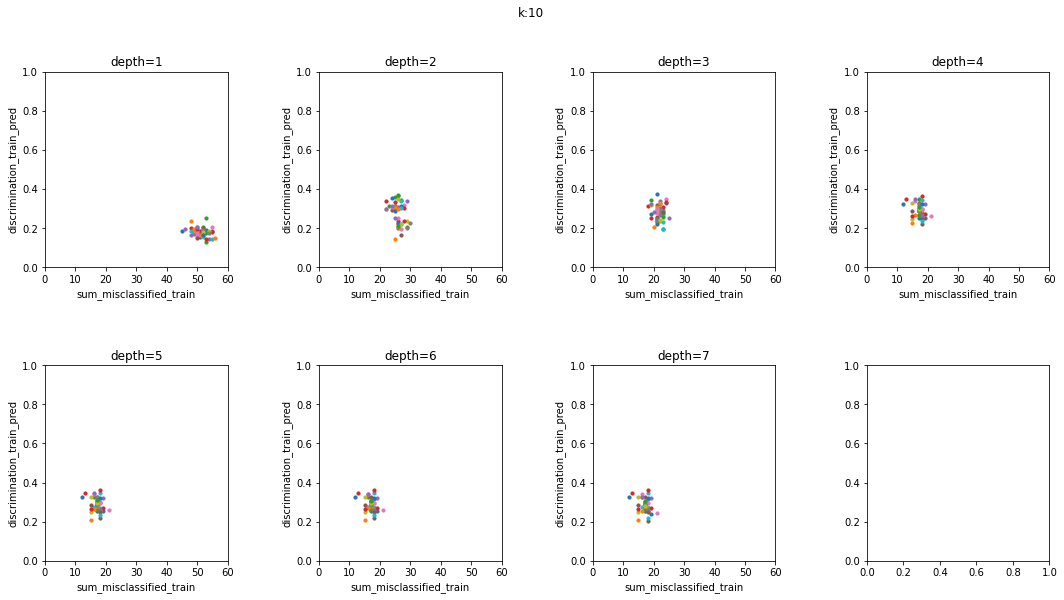

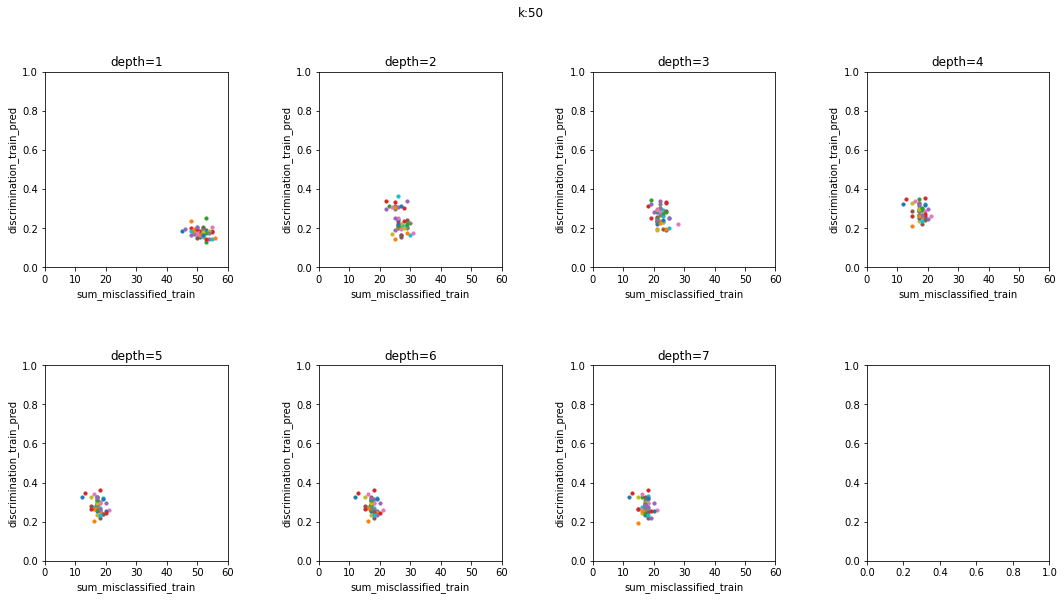

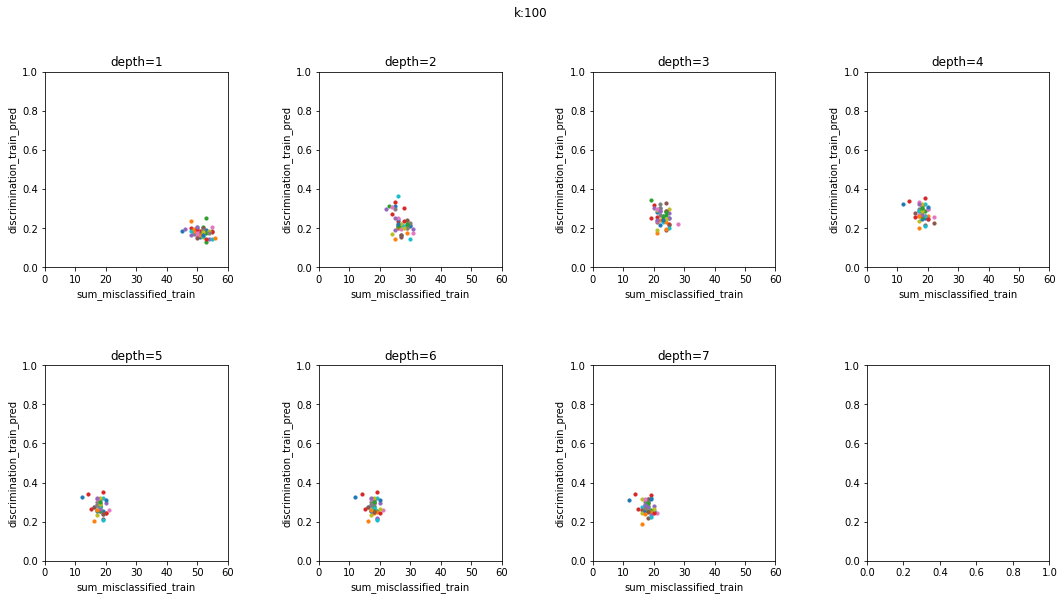

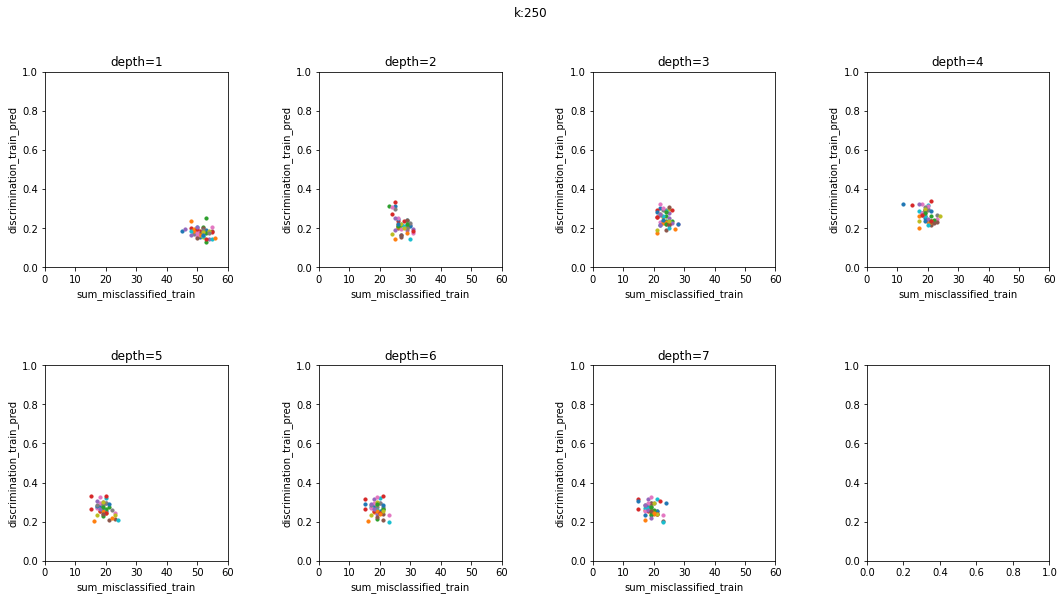

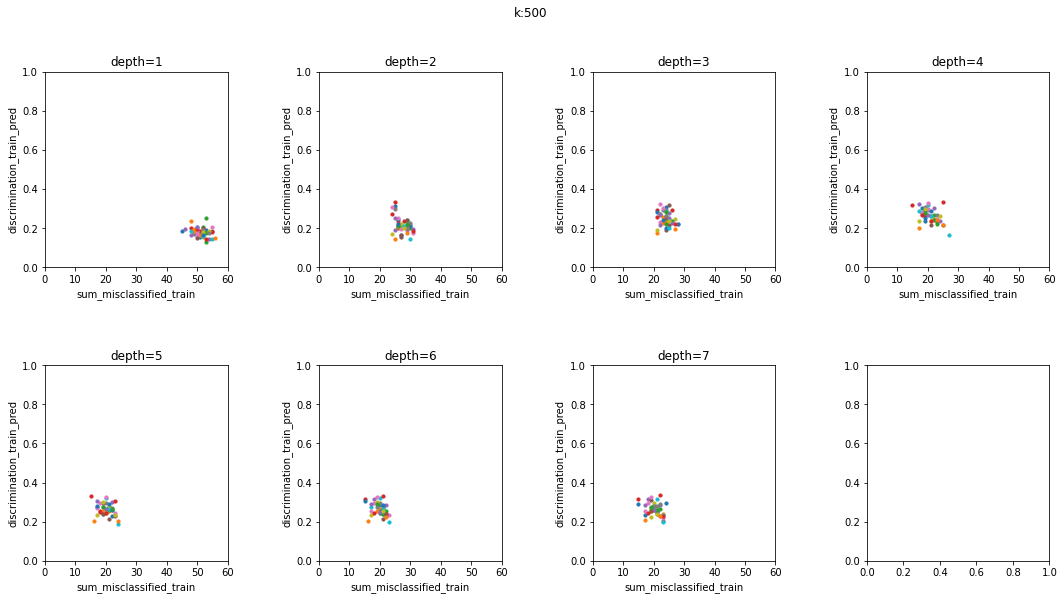

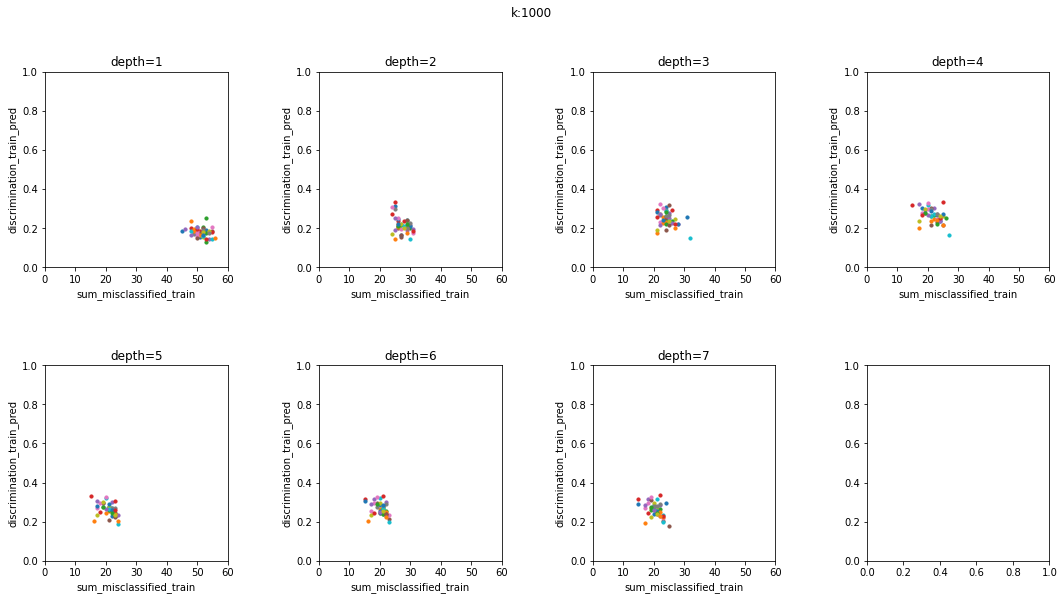

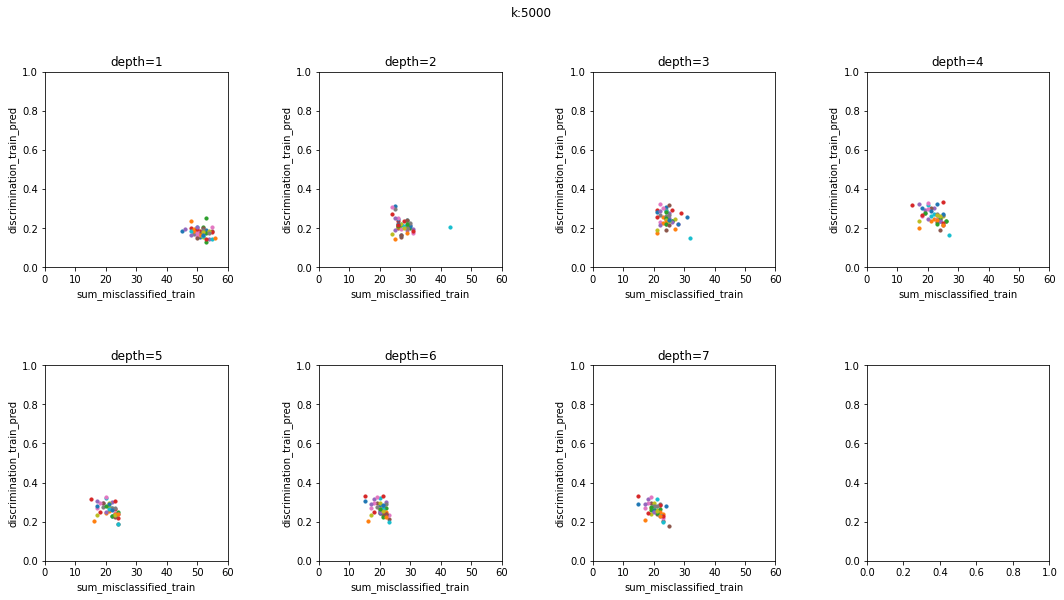

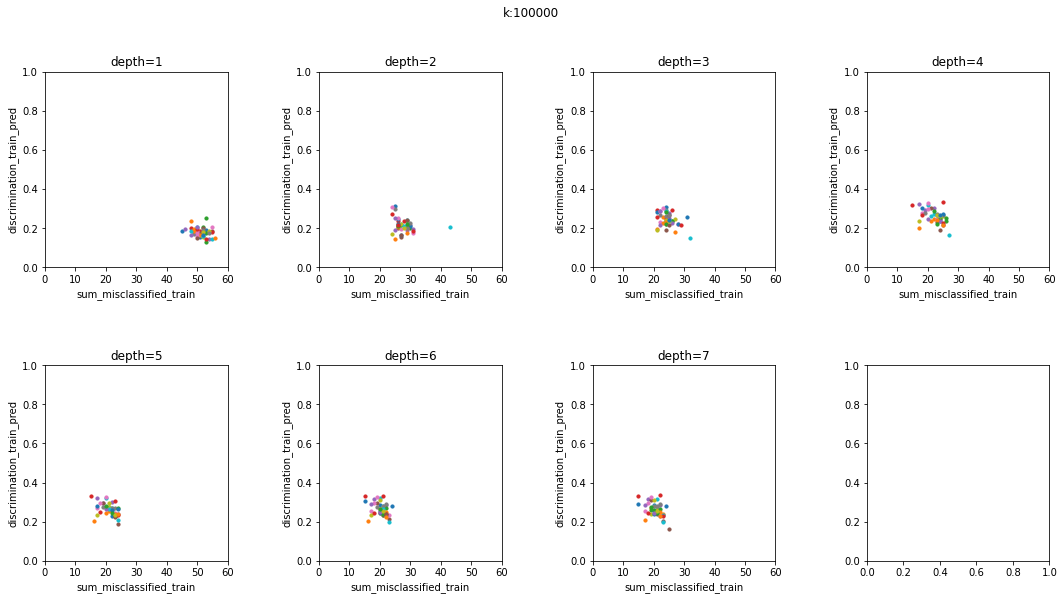

In [40]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

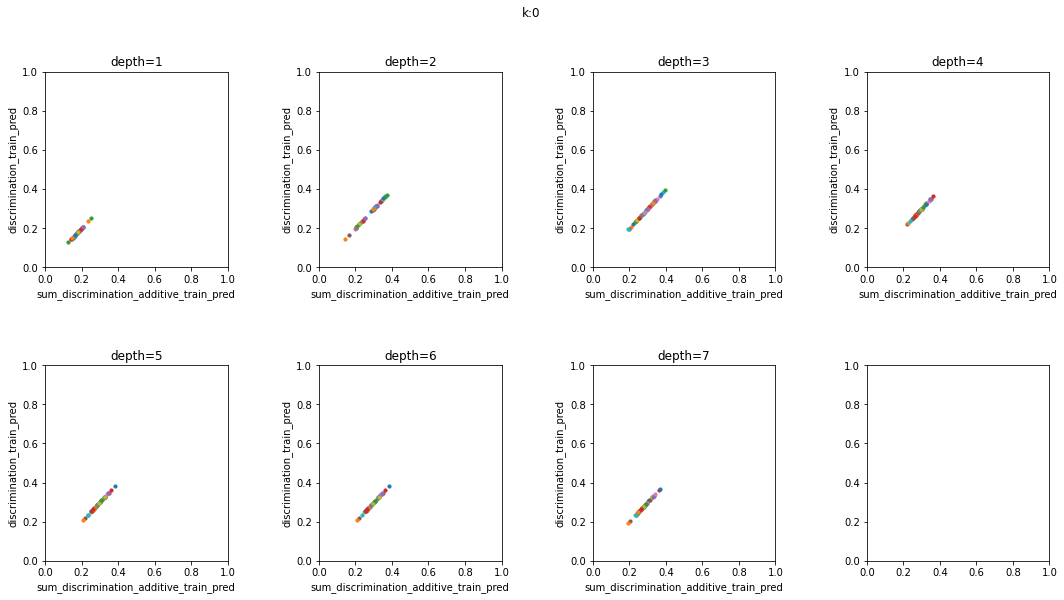

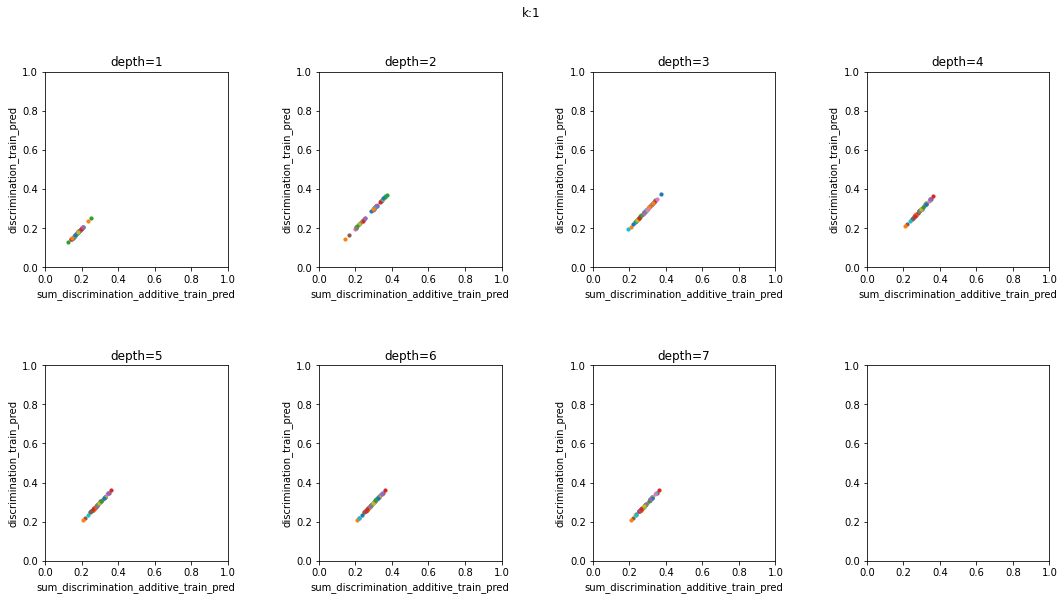

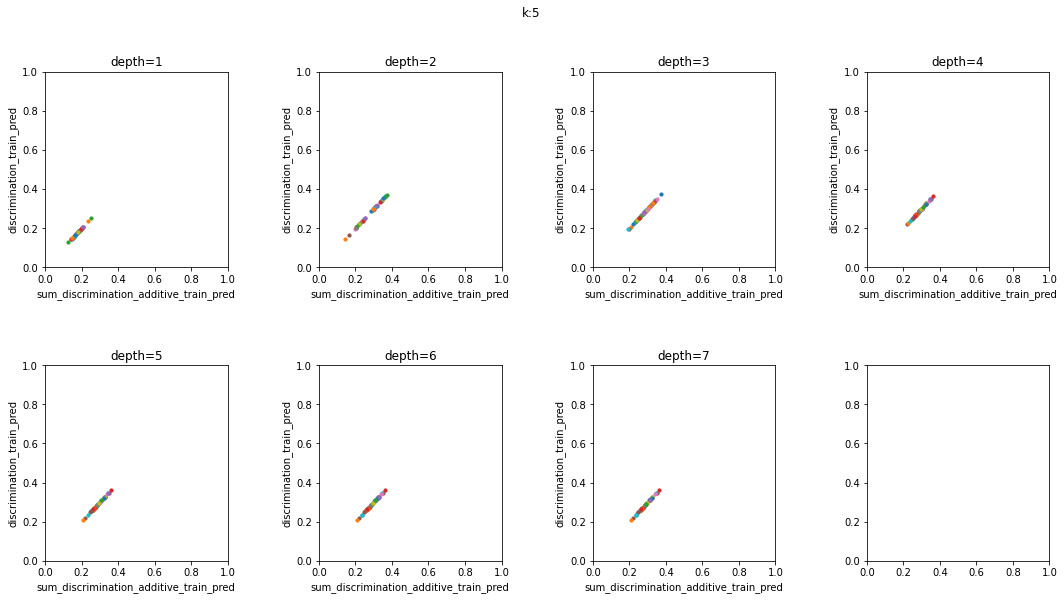

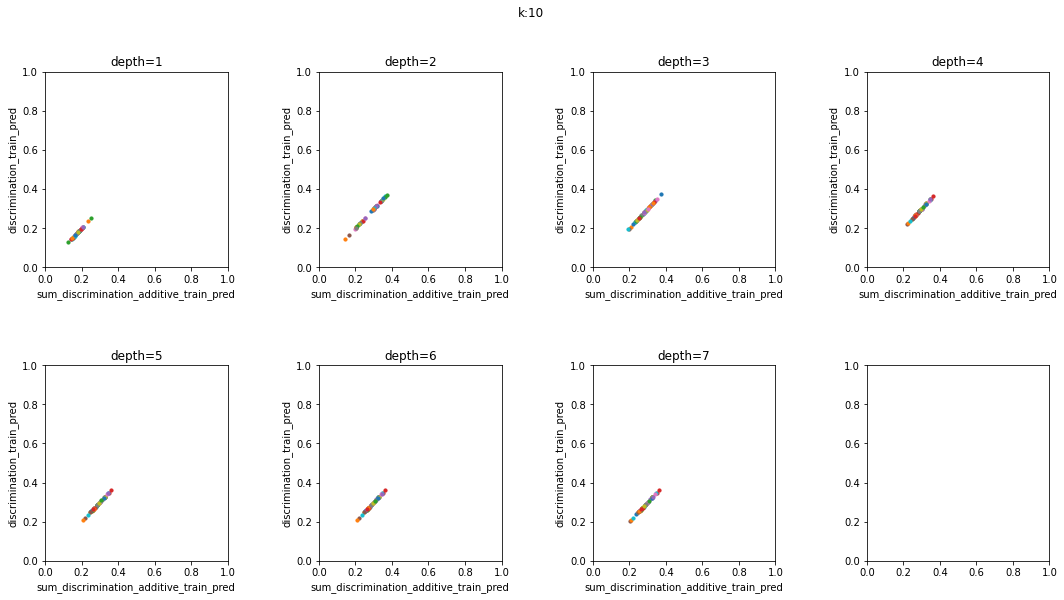

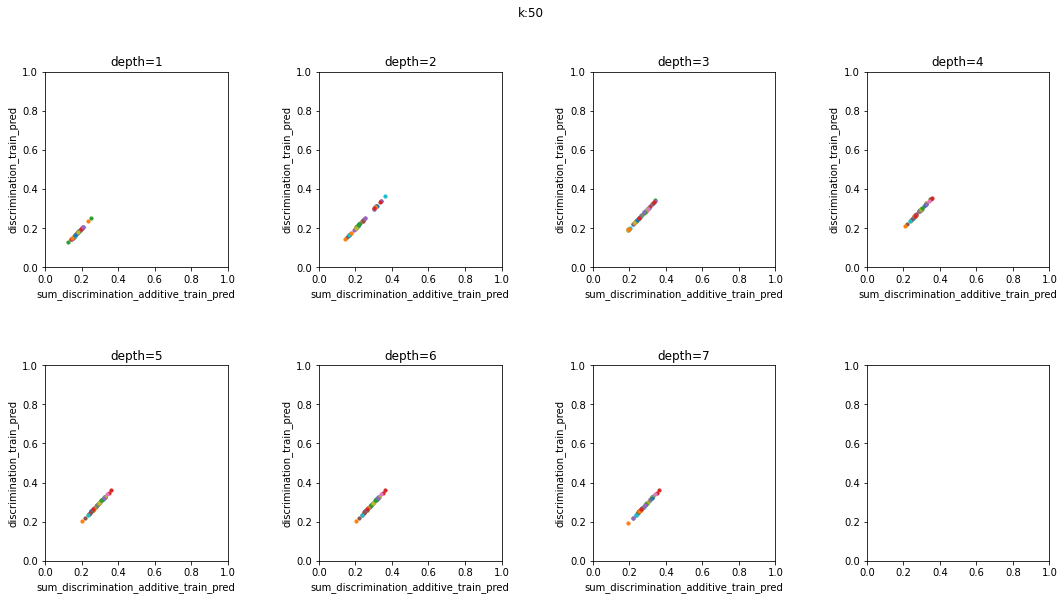

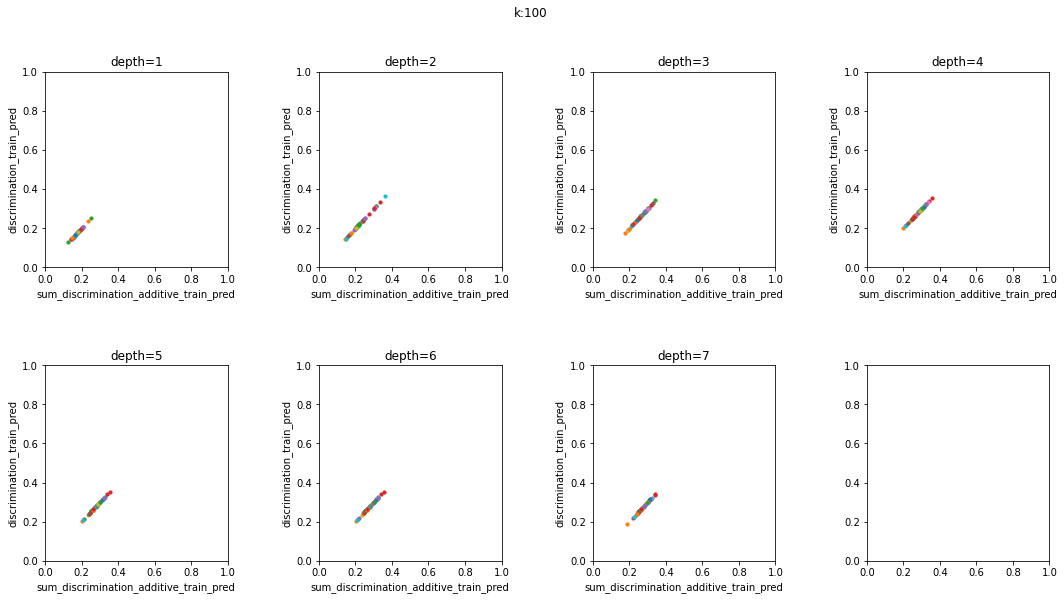

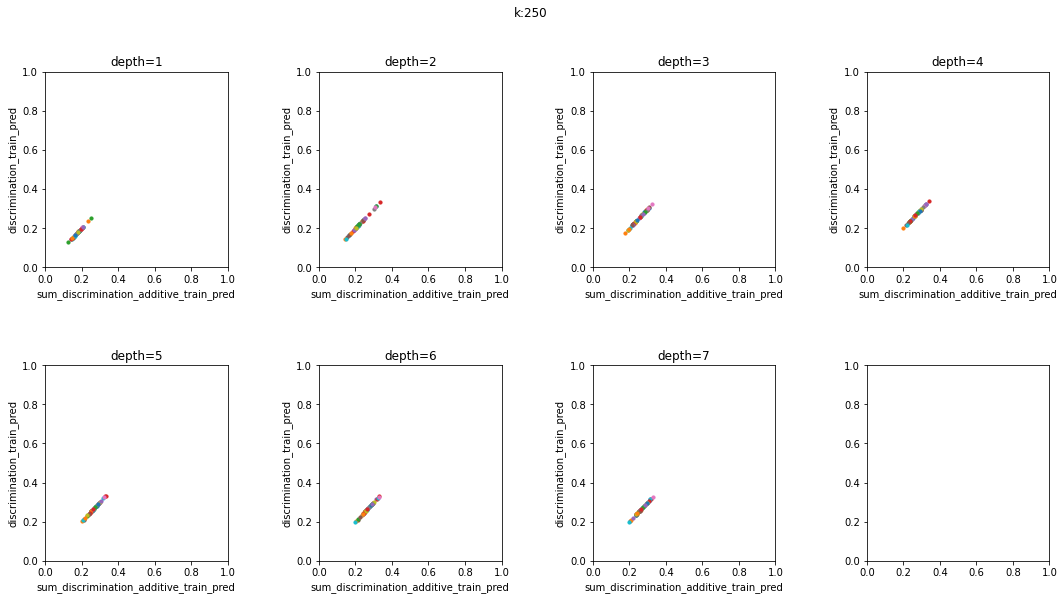

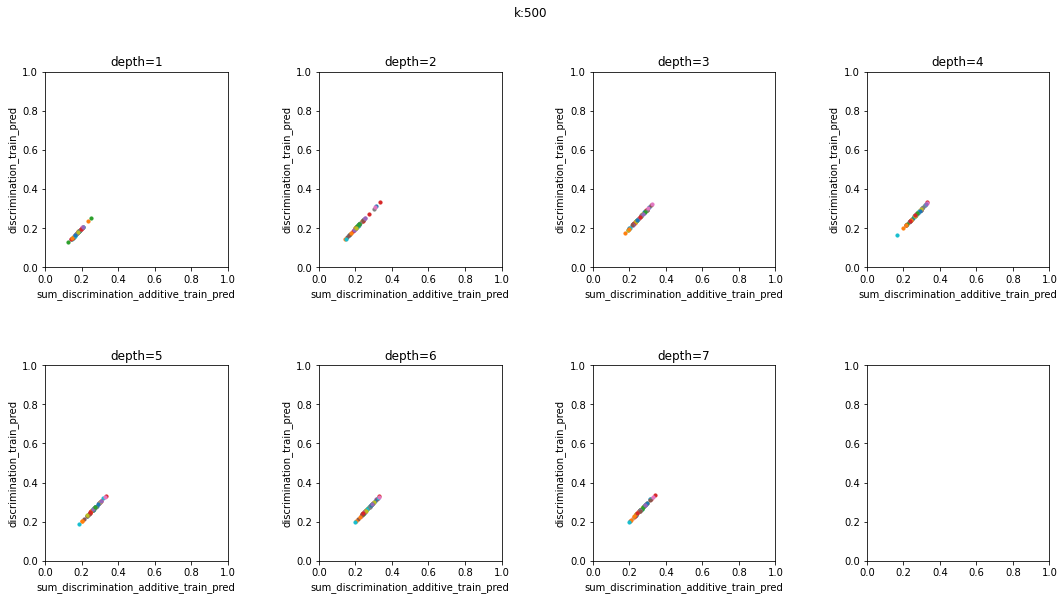

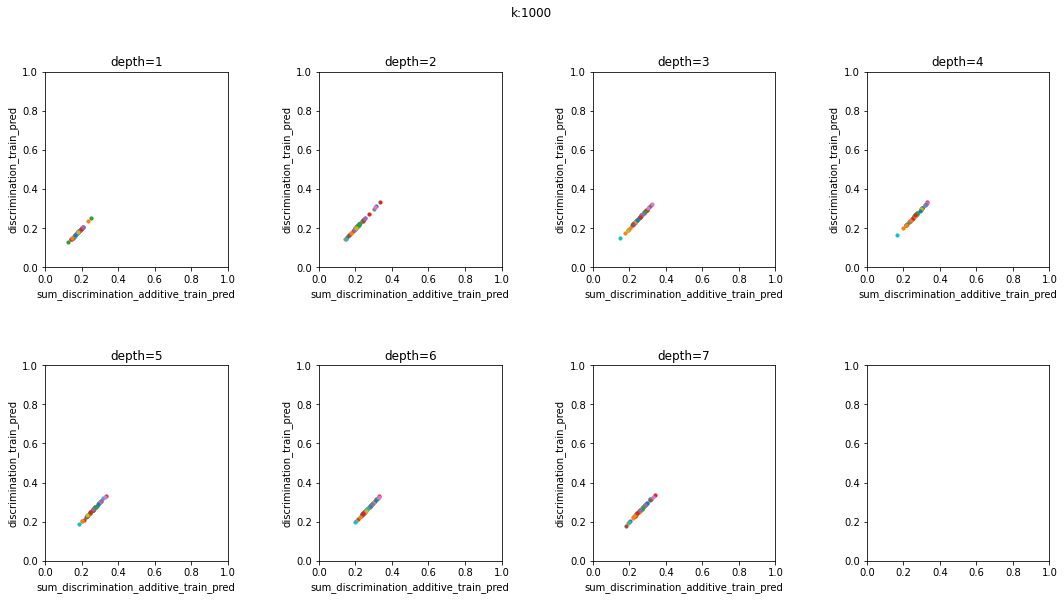

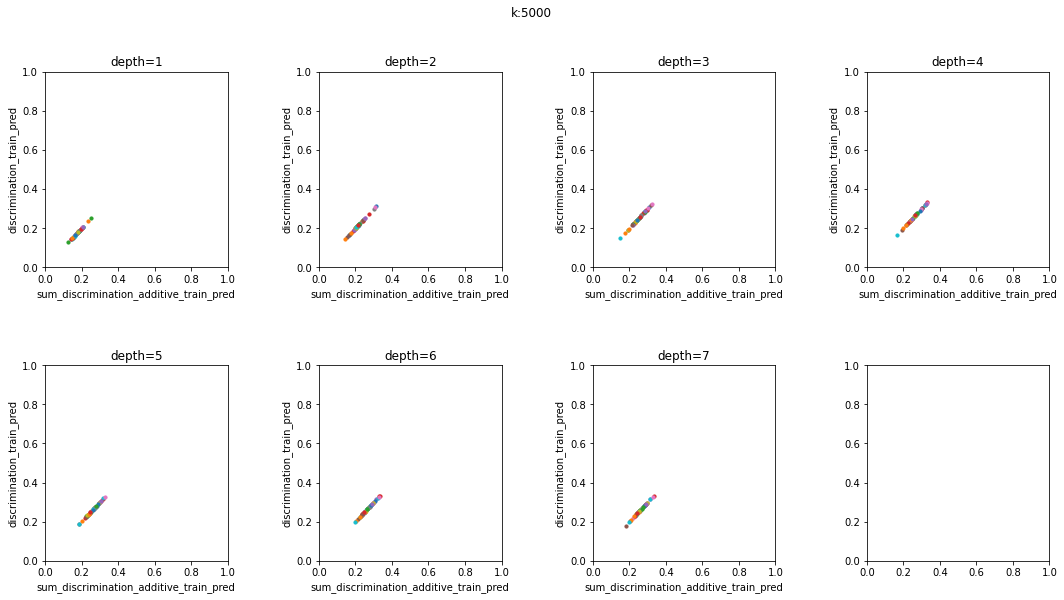

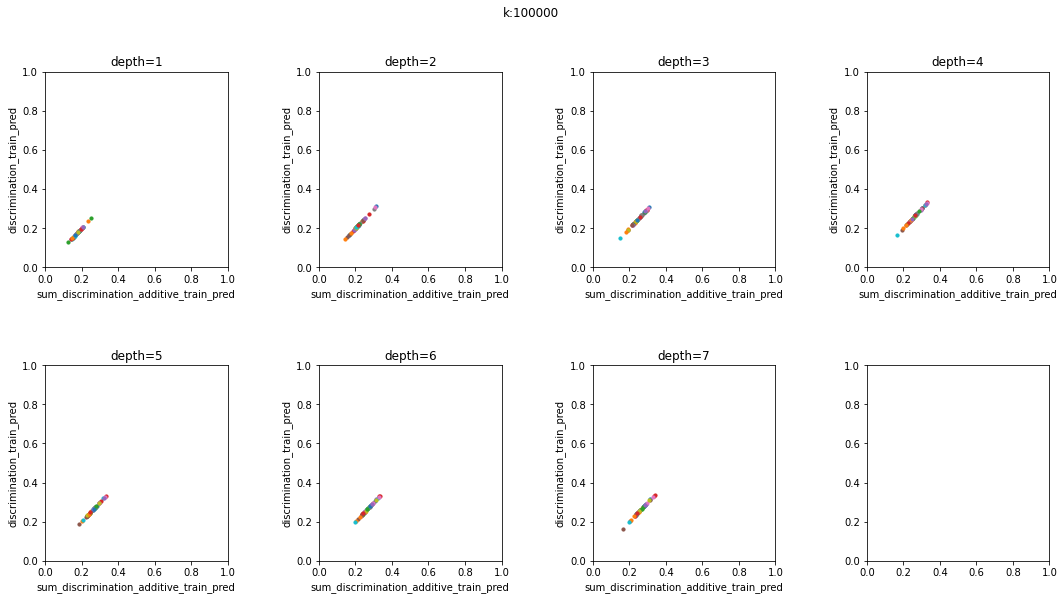

In [41]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

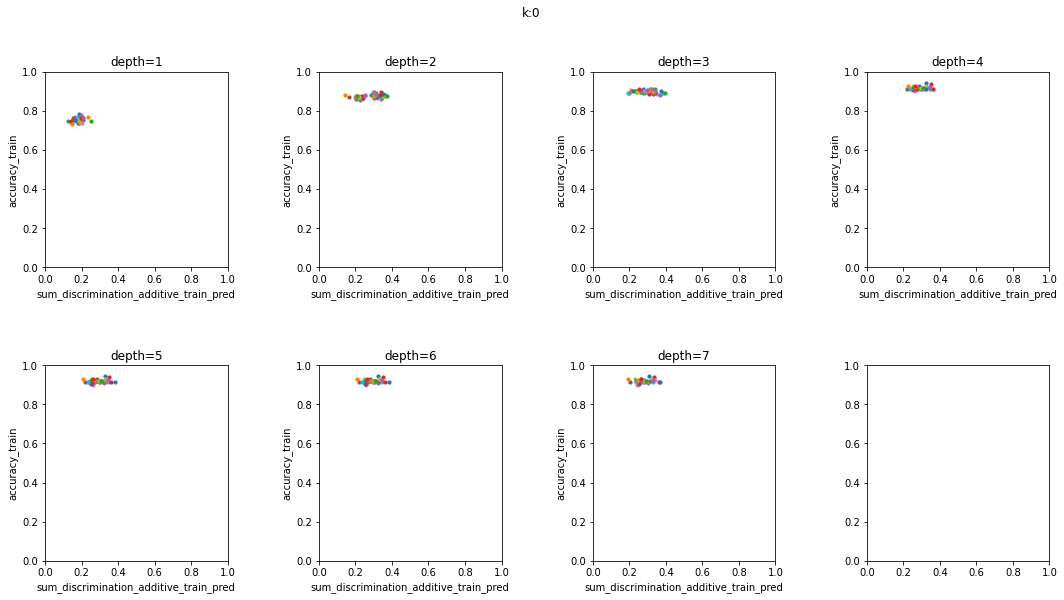

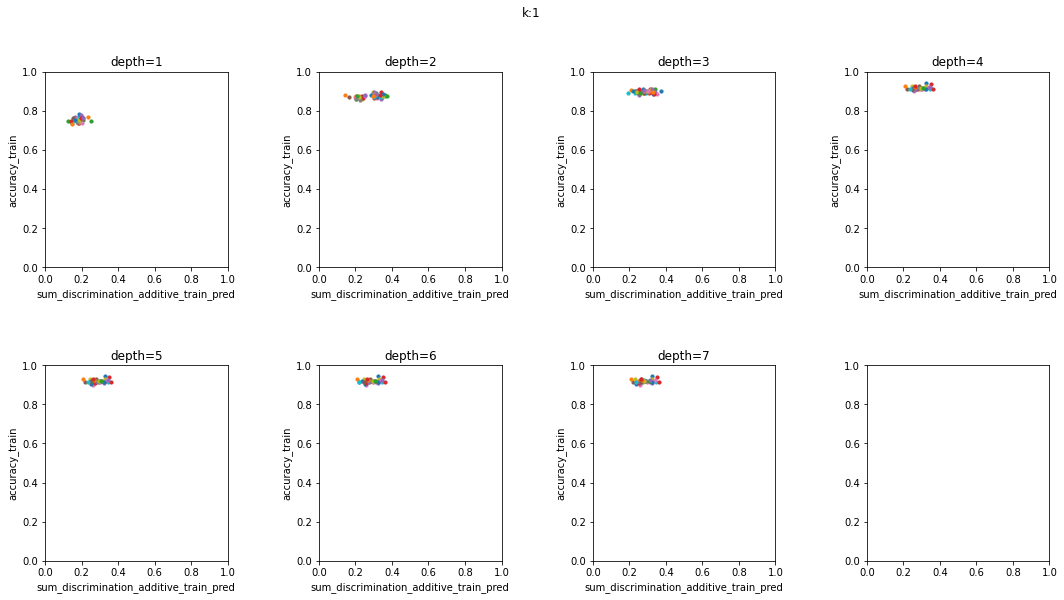

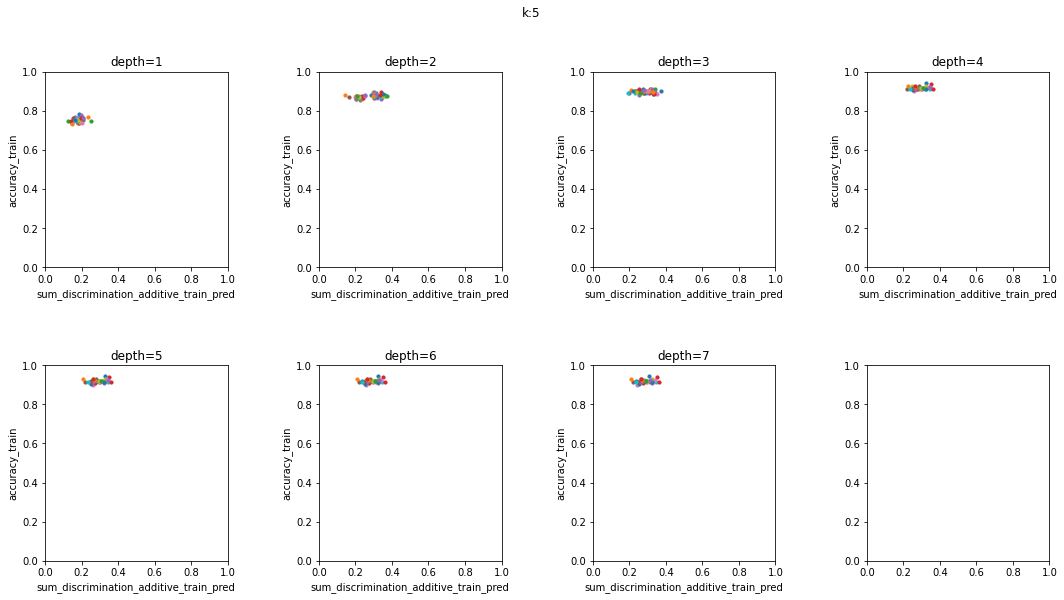

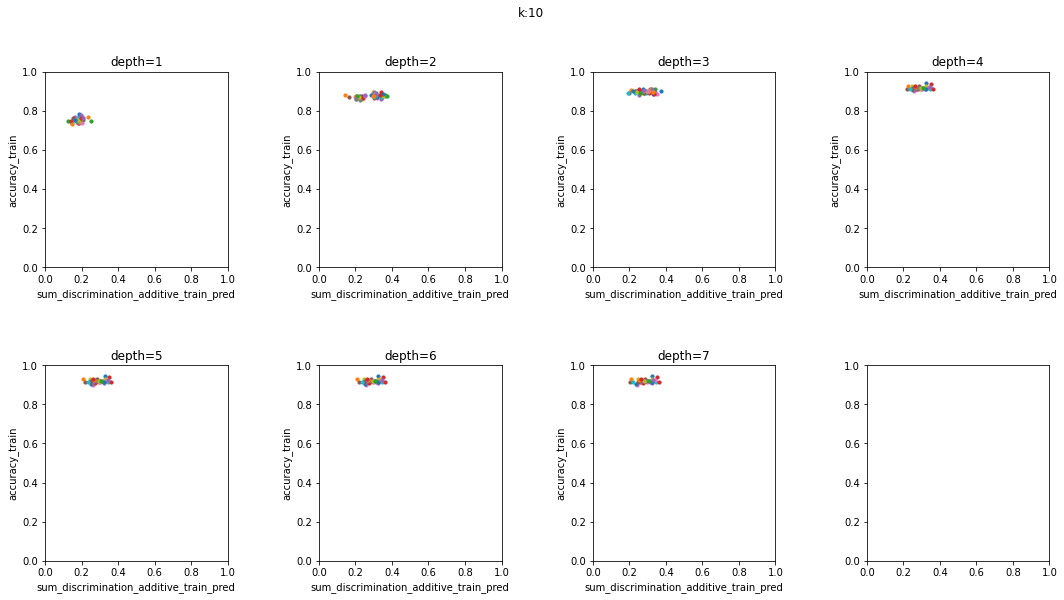

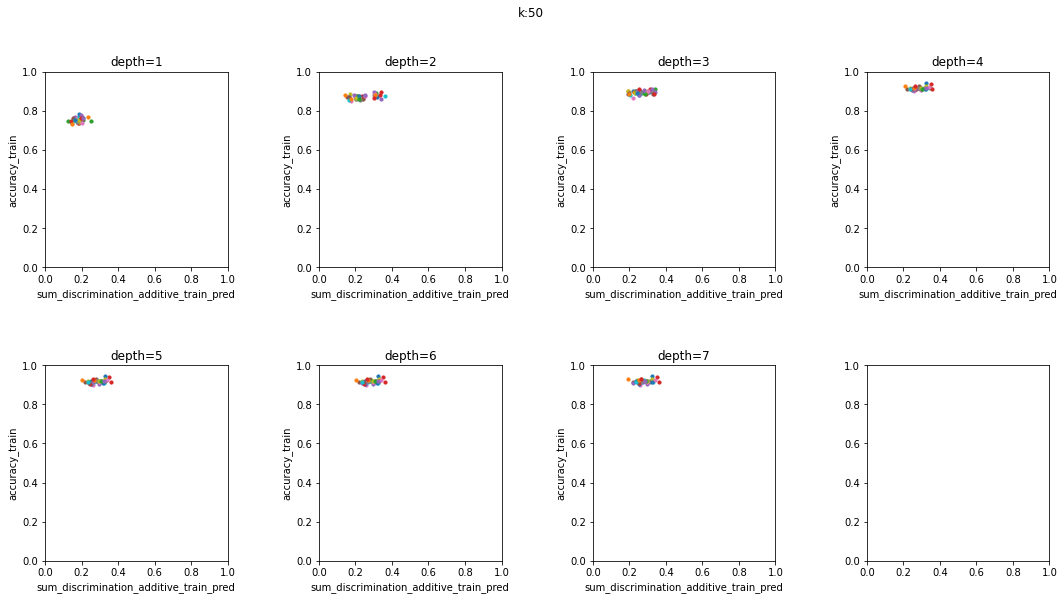

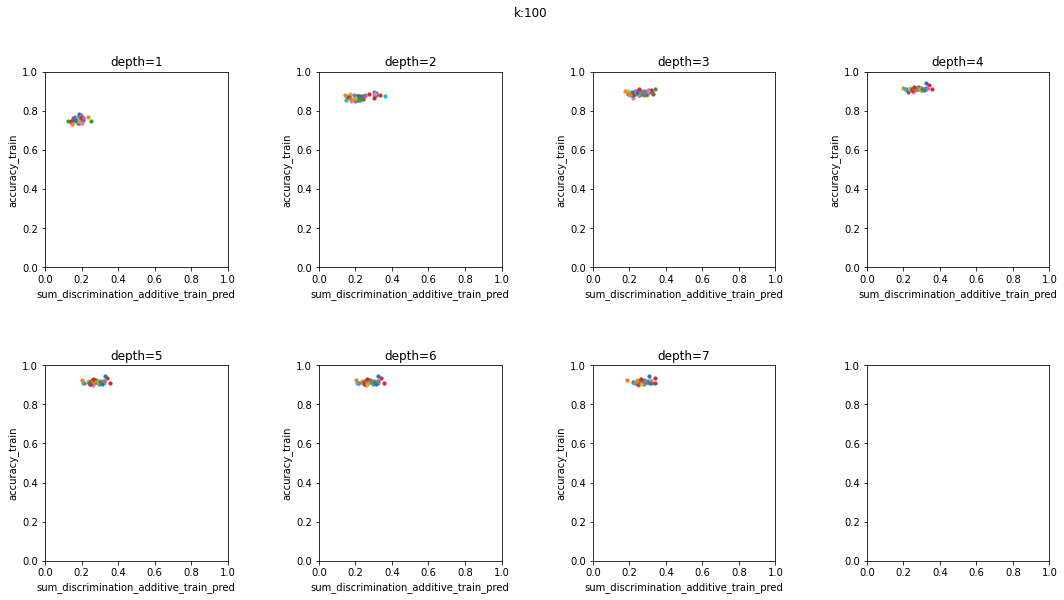

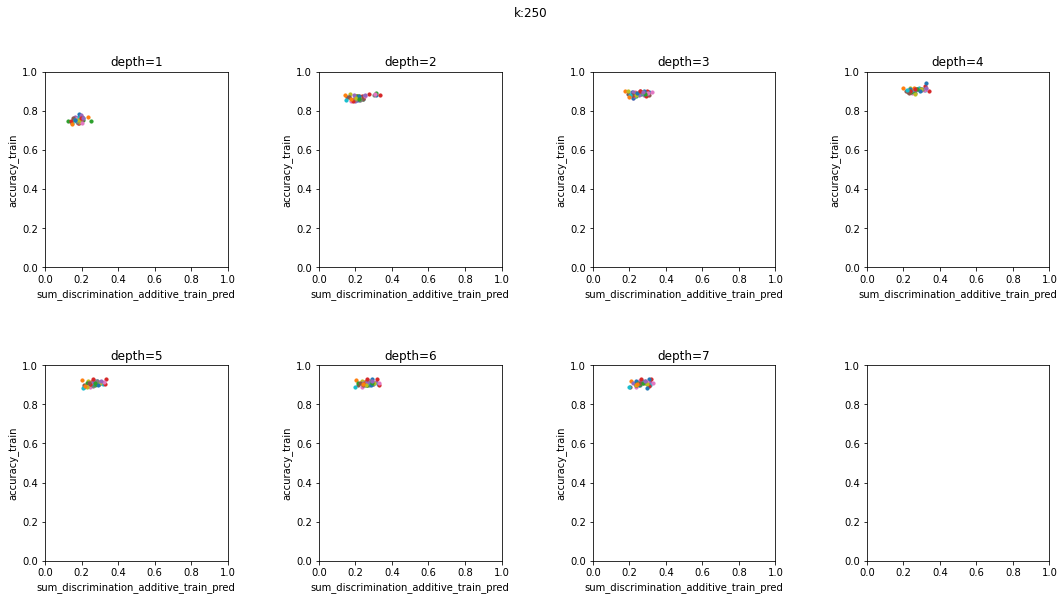

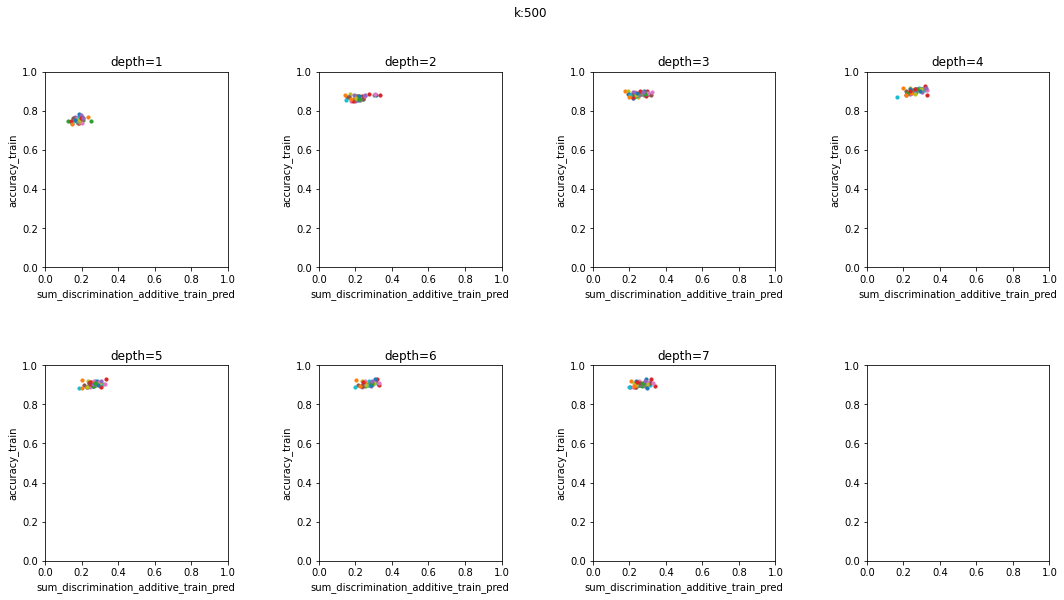

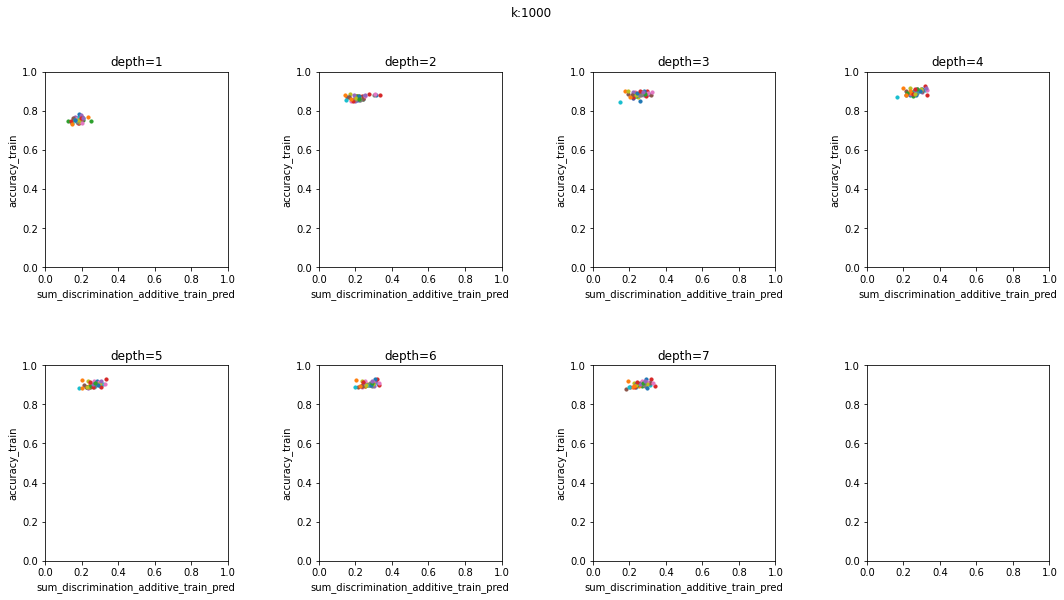

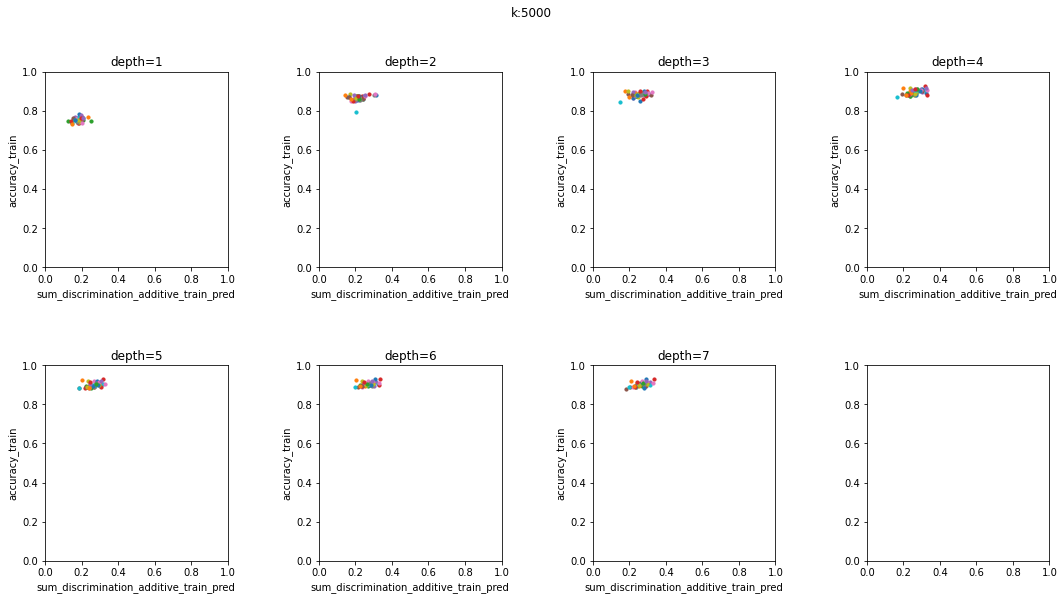

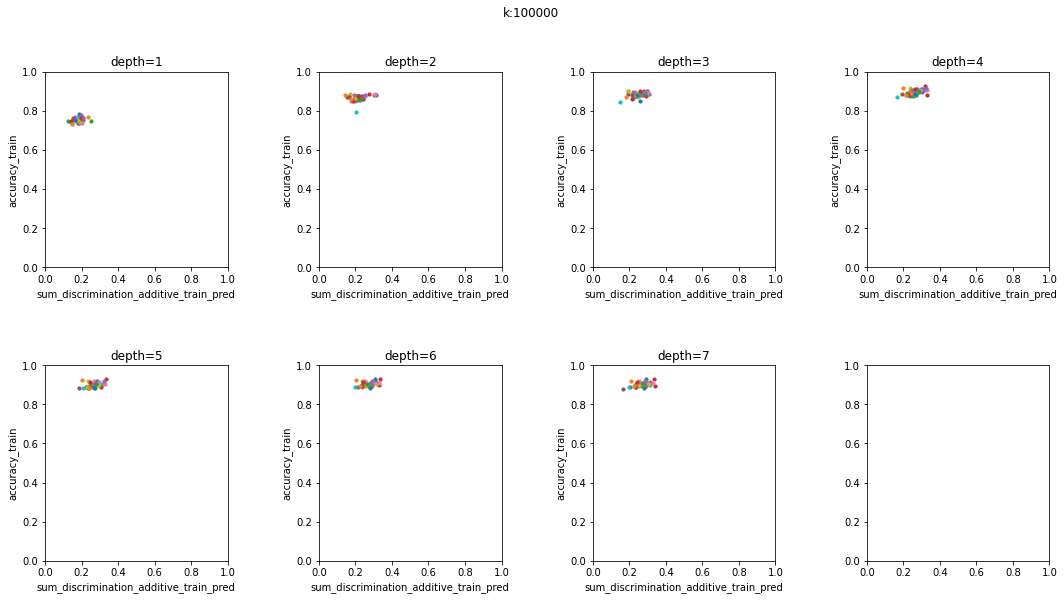

In [42]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_train", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

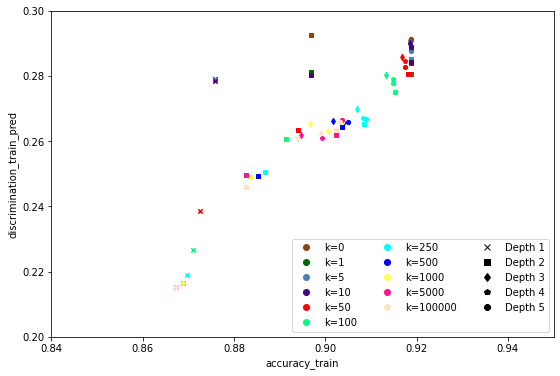

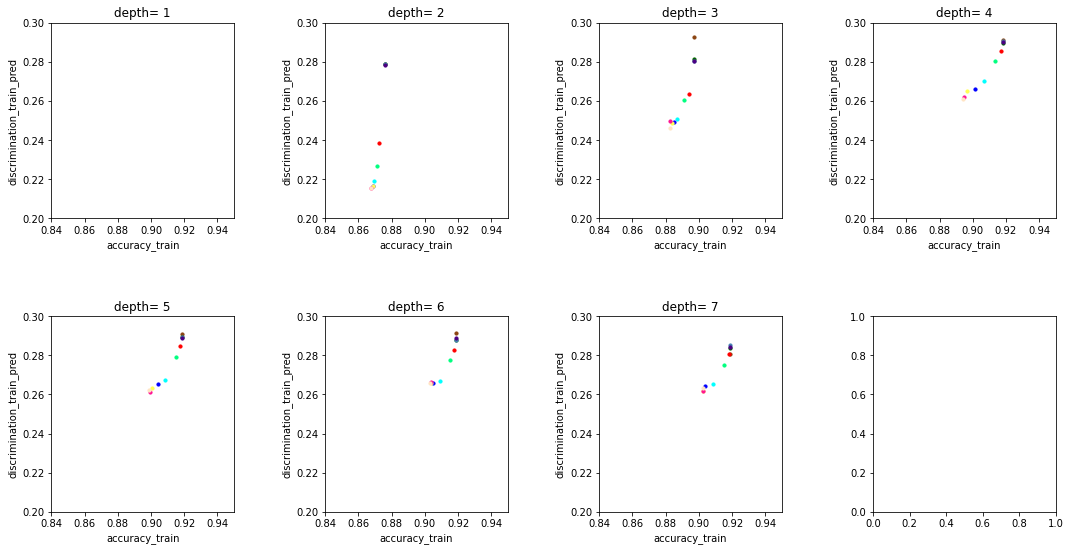

In [44]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_train", "discrimination_train_pred", result, x_lim, y_lim)
#utils.plot_each_k_depth_mean("accuracy_train", "discrimination_train", result, (0.70, 1), (0, 0.35))
utils.plot_each_k_depth_mean("accuracy_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

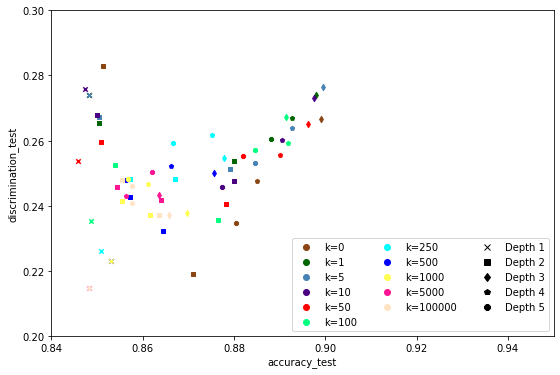

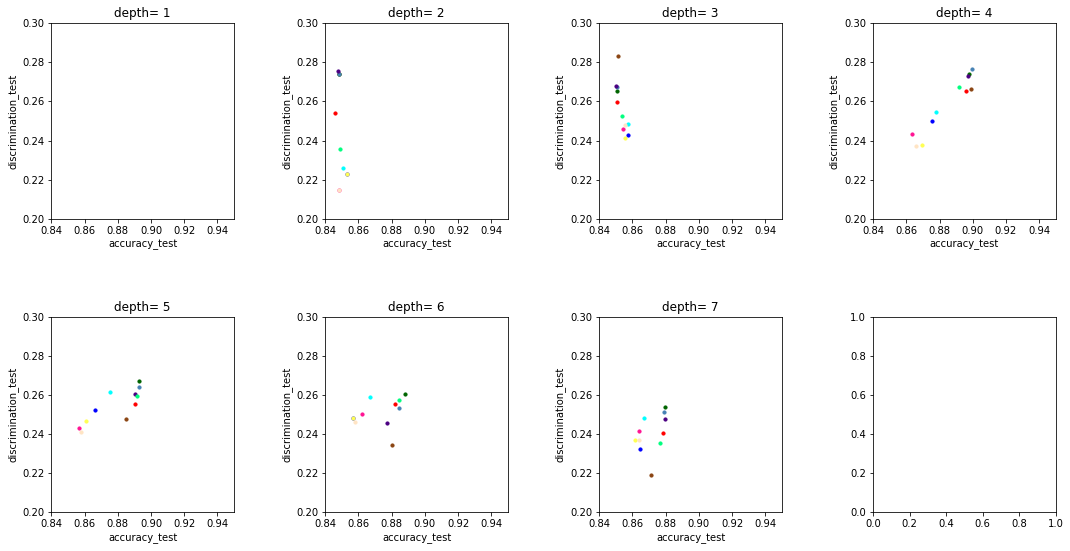

In [45]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

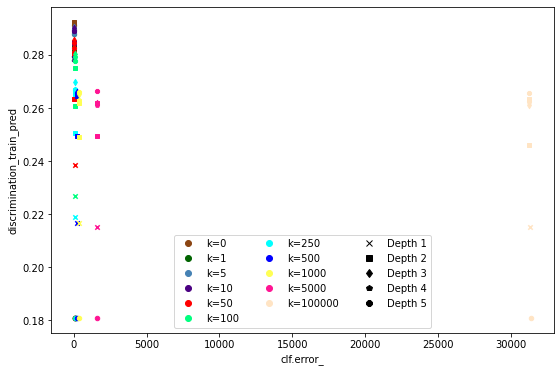

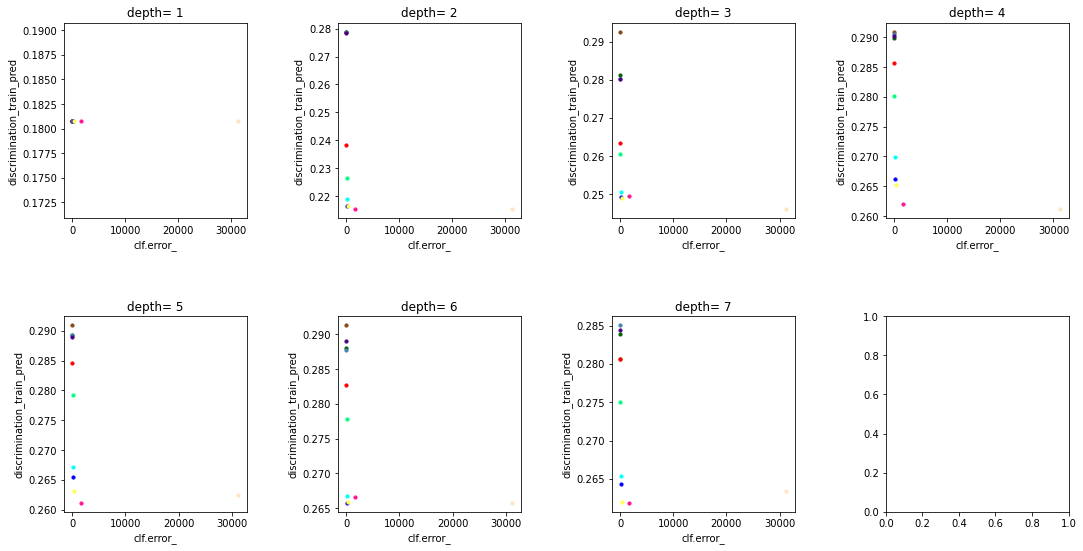

In [46]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

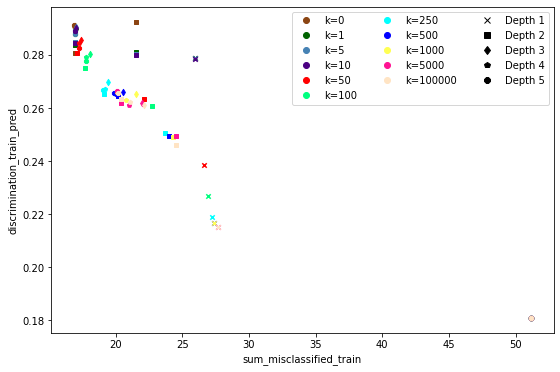

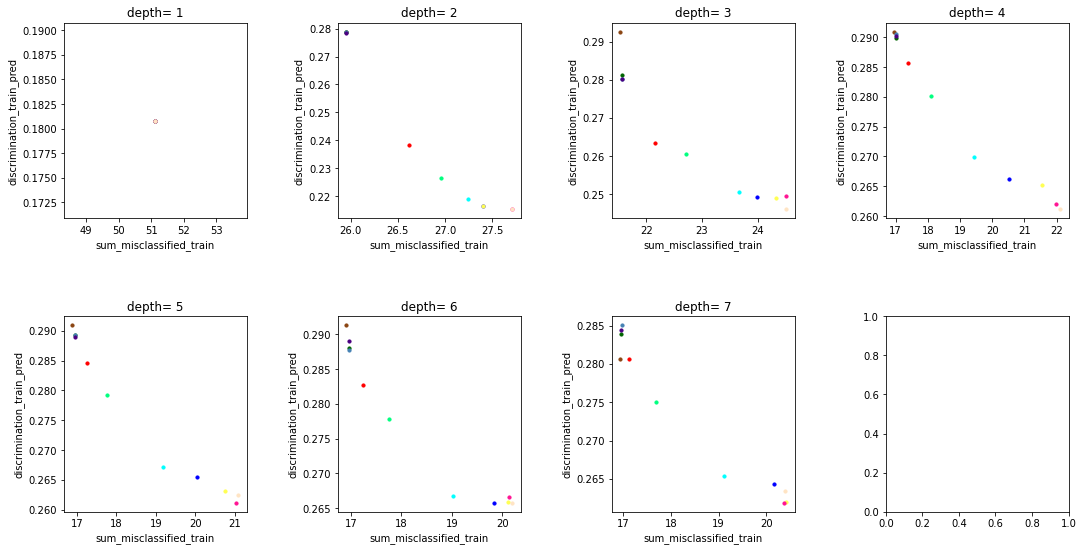

In [47]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

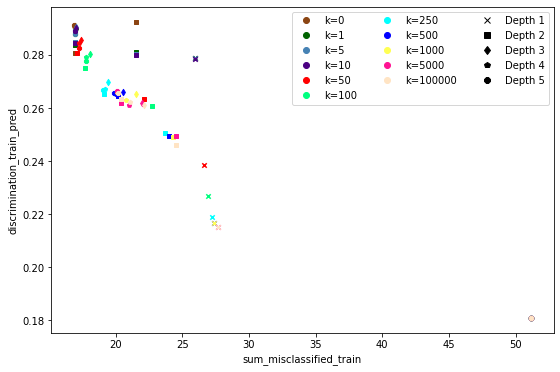

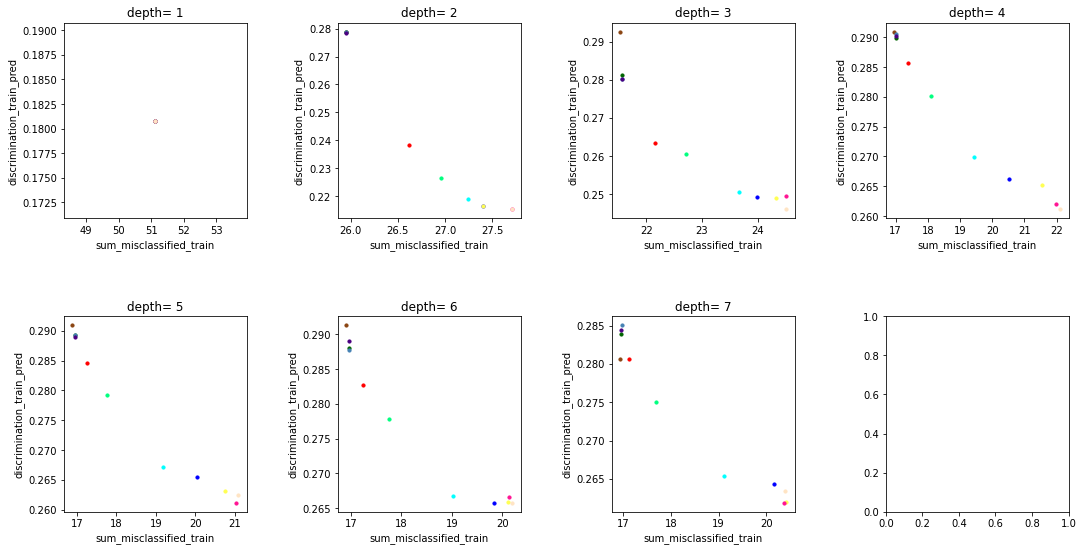

In [48]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

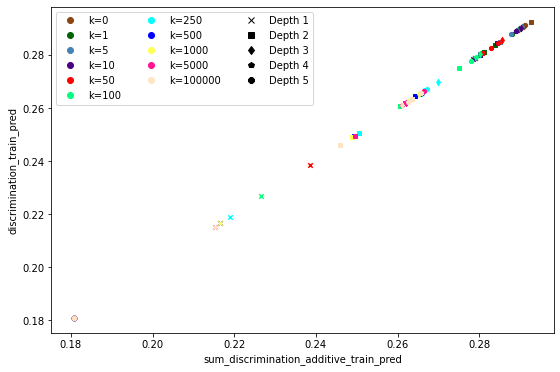

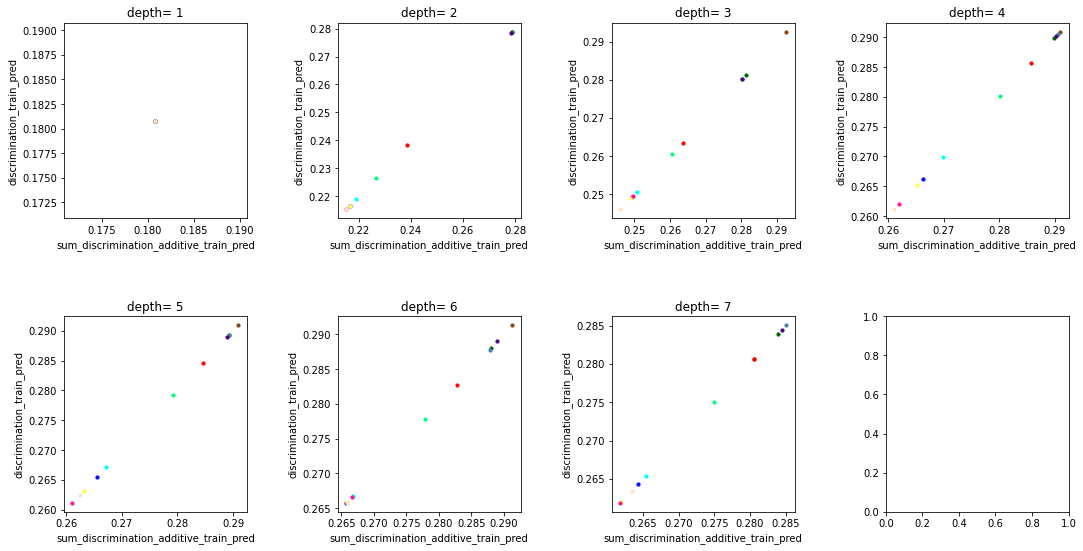

In [54]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

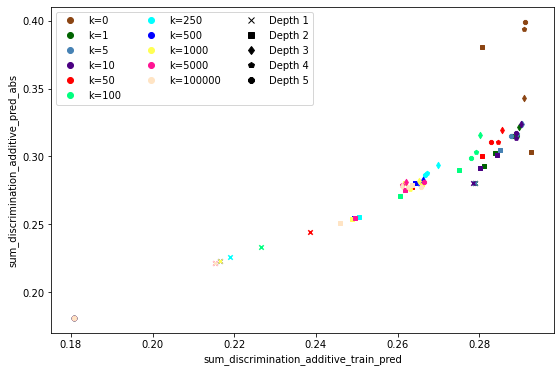

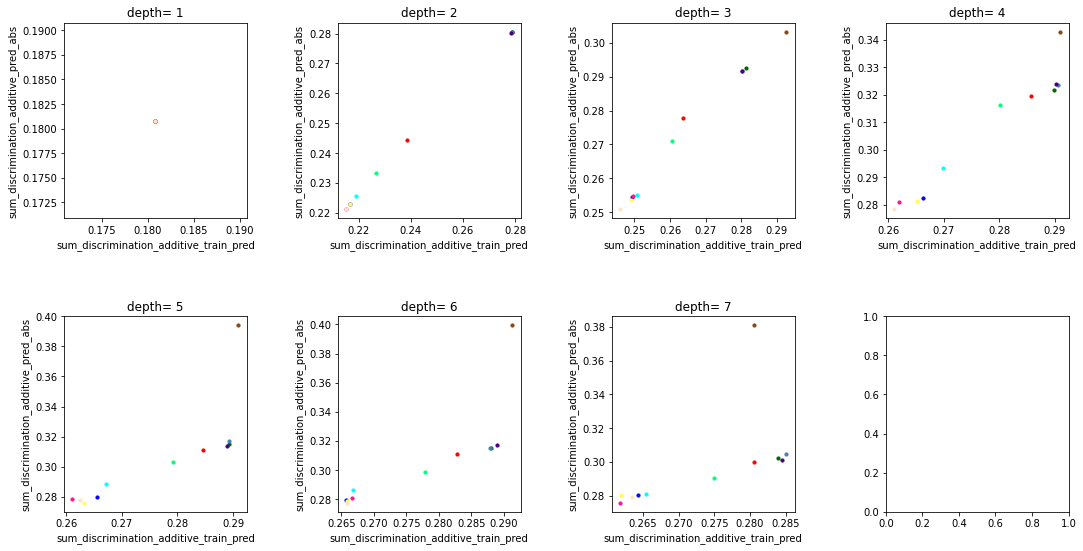

In [55]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_pred_abs", result, x_lim, y_lim)